<a href="https://colab.research.google.com/github/zeeshanahmad54/H-M-Personalized-Fashion-Recommendations/blob/main/CSCI567_team72_H_and_M_fashion_Item_Similarities_with_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and DF Setup

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
!pip install ipython-autotime
%load_ext autotime

time: 231 µs (started: 2022-05-04 23:12:34 +00:00)


In [ ]:
!pip install kaggle
!pip install sentence_transformers simcse

time: 8.06 s (started: 2022-05-04 23:12:34 +00:00)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 922 ms (started: 2022-05-04 23:12:42 +00:00)


In [ ]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))
  
# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

time: 1.86 ms (started: 2022-05-04 23:12:43 +00:00)


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering

from sentence_transformers import SentenceTransformer, util
import spacy
import pandas as pd
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
import numpy as np
import heapq


model = SentenceTransformer('stsb-roberta-large', device='cuda')

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)


time: 29.6 s (started: 2022-05-04 23:12:43 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


## Load DFs

In [ ]:
customer_df = pd.read_csv("/content/drive/MyDrive/CSCI_567_ML/Data/customers.csv")

time: 36.3 s (started: 2022-05-04 11:50:33 +00:00)


In [ ]:
article_df = pd.read_csv("/content/drive/MyDrive/CSCI_567_ML/Data/articles.csv")

In [ ]:
transaction_df = pd.read_csv("/content/drive/MyDrive/CSCI_567_ML/Data/transactions_train.csv")

time: 1min 3s (started: 2022-05-04 22:46:19 +00:00)


In [ ]:
images_folder = "/content/drive/MyDrive/CSCI_567_ML/Data/images"

time: 1.02 ms (started: 2022-05-04 12:55:20 +00:00)


## Customers

In [ ]:
# customer_id : A unique identifier of every customer
# FN : 1 or missed
# Active : 1 or missed
# club_member_status : Status in club
# fashion_news_frequency : How often H&M may send news to customer
# age : The current age
# postal_code : Postal code of customer

time: 1.69 ms (started: 2022-05-04 10:38:05 +00:00)


In [ ]:
customer_df.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a91f8ca0d4b6efa8100
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93f4c830291c32bc3057
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6c9090f7dd3e38380dc
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c222539af5973a23ae6d
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd4564743b005a805b1d


time: 18.1 ms (started: 2022-05-04 10:38:05 +00:00)


In [ ]:
data_postal = customer_df.groupby('postal_code', as_index=False).count().sort_values('customer_id', ascending=False)
data_postal.head()

,postal_code,customer_id,FN,Active,club_member_status,fashion_news_frequency,age
61034,2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c,120303,42874,39886,118281,114377,118002
281937,cc4ed85e30f4977dae47662ddc468cd2eec11472de6fac5ec985080fd92243c8,261,109,104,261,261,260
156090,714976379549eb90aae4a71bca6c7402cc646ae7c40f6c1cb91d4b5a18623fc1,159,90,88,159,159,158
171208,7c1fa3b0ec1d37ce2c3f34f63bd792f3b4494f324b6be5d1e4ba6a75456b96a7,157,55,54,157,156,156
126228,5b7eb31eabebd3277de632b82267286d847fd5d44287ee150bb4206b48439145,156,42,41,156,156,155


time: 1.87 s (started: 2022-05-04 10:38:05 +00:00)


In [ ]:
len(data_postal)

352899

time: 2.96 ms (started: 2022-05-04 10:38:07 +00:00)


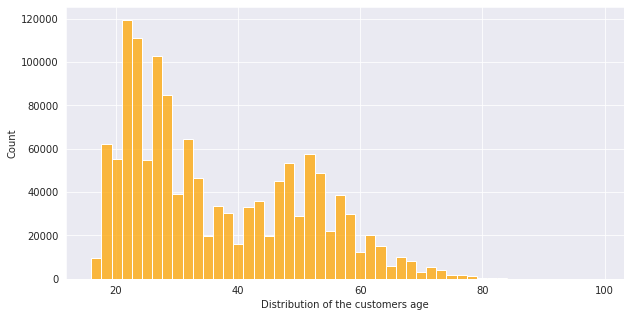

time: 626 ms (started: 2022-05-04 10:38:07 +00:00)


In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=customer_df, x='age', bins=50, color='orange')
ax.set_xlabel('Distribution of the customers age')
plt.show()

## Articles

In [ ]:
# article_id : A unique identifier of every article.
# product_code, prod_name : A unique identifier of every product and its name (not the same).
# product_type, product_type_name : The group of product_code and its name
# graphical_appearance_no, graphical_appearance_name : The group of graphics and its name
# colour_group_code, colour_group_name : The group of color and its name
# perceived_colour_value_id, perceived_colour_value_name, perceived_colour_master_id, perceived_colour_master_name : The added color info
# department_no, department_name: : A unique identifier of every dep and its name
# index_code, index_name: : A unique identifier of every index and its name
# index_group_no, index_group_name: : A group of indeces and its name
# section_no, section_name: : A unique identifier of every section and its name
# garment_group_no, garment_group_name: : A unique identifier of every garment and its name
# detail_desc: : Details

time: 2.85 ms (started: 2022-05-04 10:38:07 +00:00)


In [ ]:
article_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort."


time: 17.6 ms (started: 2022-05-04 10:38:07 +00:00)


### Item (index_name) frequencies


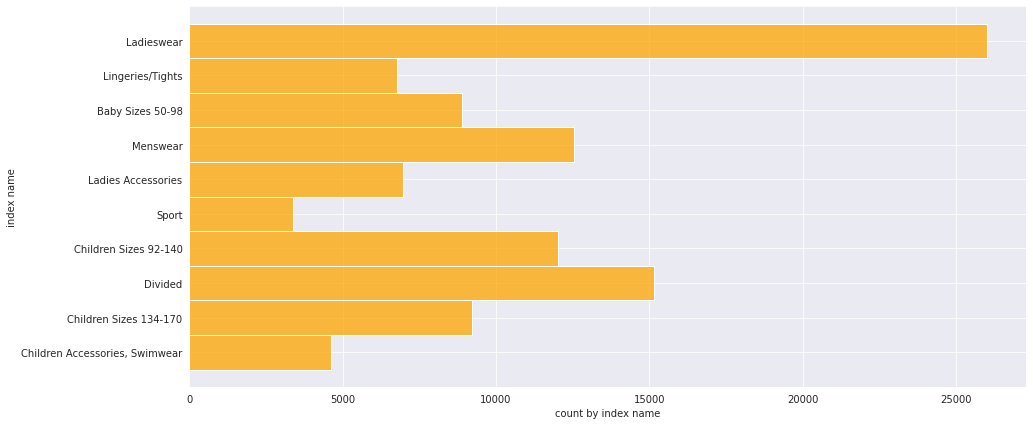

time: 361 ms (started: 2022-05-04 10:38:07 +00:00)


In [ ]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=article_df, y='index_name', color='orange')
ax.set_xlabel('count by index name')
ax.set_ylabel('index name')
plt.show()

### Garment group frequencies

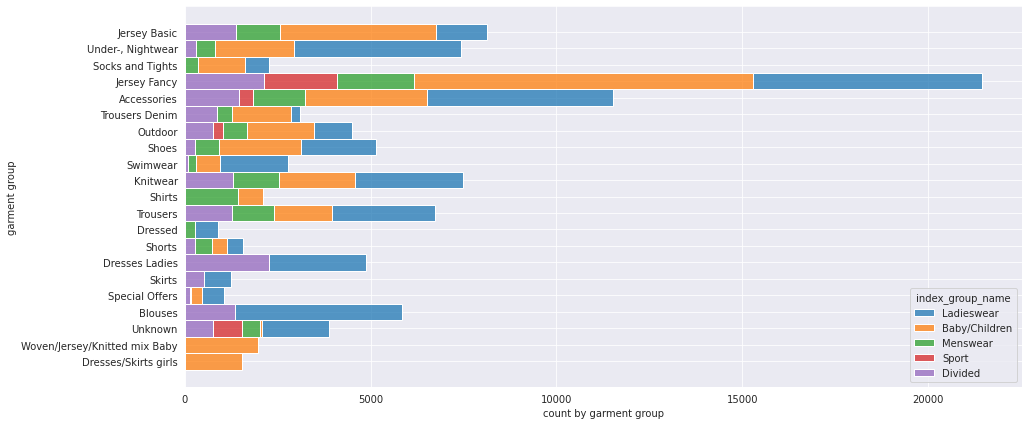

time: 717 ms (started: 2022-05-04 10:38:08 +00:00)


In [ ]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=article_df, y='garment_group_name', color='orange', hue='index_group_name', multiple="stack")
ax.set_xlabel('count by garment group')
ax.set_ylabel('garment group')
plt.show()

In [ ]:
article_df.groupby(['index_group_name', 'index_name']).count()['article_id']


index_group_name  index_name                    
Baby/Children     Baby Sizes 50-98                  8875 
                  Children Accessories, Swimwear    4615 
                  Children Sizes 134-170            9214 
                  Children Sizes 92-140             12007
Divided           Divided                           15149
Ladieswear        Ladies Accessories                6961 
                  Ladieswear                        26001
                  Lingeries/Tights                  6775 
Menswear          Menswear                          12553
Sport             Sport                             3392 
Name: article_id, dtype: int64

time: 107 ms (started: 2022-05-04 10:38:09 +00:00)


### product group-product structure

In [ ]:
pd.options.display.max_rows = None
article_df.groupby(['product_group_name', 'product_type_name']).count()['article_id']

product_group_name     product_type_name       
Accessories            Accessories set             7    
                       Alice band                  6    
                       Baby Bib                    3    
                       Bag                         1280 
                       Beanie                      56   
                       Belt                        458  
                       Bracelet                    180  
                       Braces                      3    
                       Bucket hat                  7    
                       Cap                         13   
                       Cap/peaked                  573  
                       Dog Wear                    20   
                       Earring                     1159 
                       Earrings                    11   
                       Eyeglasses                  2    
                       Felt hat                    10   
                       Giftbox          

time: 114 ms (started: 2022-05-04 10:38:09 +00:00)


In [ ]:
# unique values in columns

for col in article_df.columns:
    if not 'no' in col and not 'code' in col and not 'id' in col:
        un_n = article_df[col].nunique()
        print(f'n of unique {col}: {un_n}')

n of unique prod_name: 45875
n of unique product_type_name: 131
n of unique product_group_name: 19
n of unique graphical_appearance_name: 30
n of unique colour_group_name: 50
n of unique perceived_colour_value_name: 8
n of unique perceived_colour_master_name: 20
n of unique department_name: 250
n of unique index_name: 10
n of unique index_group_name: 5
n of unique section_name: 56
n of unique garment_group_name: 21
n of unique detail_desc: 43404
time: 104 ms (started: 2022-05-04 10:38:09 +00:00)


### Product Similarities

In [ ]:
article_df.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

time: 4.6 ms (started: 2022-05-04 10:38:09 +00:00)


In [ ]:
print(np.sort(article_df['product_type_name'].unique()))

['Accessories set' 'Alice band' 'Baby Bib' 'Backpack' 'Bag' 'Ballerinas'
 'Beanie' 'Belt' 'Bikini top' 'Blanket' 'Blazer' 'Blouse' 'Bodysuit'
 'Bootie' 'Boots' 'Bra' 'Bra extender' 'Bracelet' 'Braces' 'Bucket hat'
 'Bumbag' 'Cap' 'Cap/peaked' 'Cardigan' 'Chem. cosmetics' 'Clothing mist'
 'Coat' 'Costumes' 'Cross-body bag' 'Cushion' 'Dog Wear' 'Dog wear'
 'Dress' 'Dungarees' 'Earring' 'Earrings' 'Eyeglasses' 'Felt hat'
 'Fine cosmetics' 'Flat shoe' 'Flat shoes' 'Flip flop' 'Garment Set'
 'Giftbox' 'Gloves' 'Hair clip' 'Hair string' 'Hair ties'
 'Hair/alice band' 'Hairband' 'Hat/beanie' 'Hat/brim' 'Headband'
 'Heeled sandals' 'Heels' 'Hoodie' 'Jacket' 'Jumpsuit/Playsuit' 'Keychain'
 'Kids Underwear top' 'Leg warmers' 'Leggings/Tights' 'Long John'
 'Marker pen' 'Mobile case' 'Moccasins' 'Necklace' 'Night gown'
 'Nipple covers' 'Other accessories' 'Other shoe' 'Outdoor Waistcoat'
 'Outdoor overall' 'Outdoor trousers' 'Polo shirt' 'Pre-walkers' 'Pumps'
 'Pyjama bottom' 'Pyjama jumpsuit/play

In [ ]:
pd.set_option('display.max_colwidth', -1)


time: 1.12 ms (started: 2022-05-04 10:38:09 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


## Transactions

In [ ]:
# t_dat : A unique identifier of every customer
# customer_id : A unique identifier of every customer (in customers table)
# article_id : A unique identifier of every article (in articles table)
# price : Price of purchase
# sales_channel_id : 1 or 2

time: 743 µs (started: 2022-05-04 10:38:09 +00:00)


In [ ]:
transaction_df.loc[transaction_df['customer_id'] == customer_df.iloc[0]['customer_id']]
# transaction_df[transaction_df['customer_id'].str.contains("000058a12d5b43e67d225668fa1f8d618c13dc232df0ca")]

,t_dat,customer_id,article_id,price,sales_channel_id
4212358,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,625548001,0.044051,1
4212359,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,176209023,0.035576,1
4212360,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,627759010,0.030492,1
9663224,2019-05-02,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,697138006,0.010153,2
10754876,2019-05-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,568601006,0.050831,2
10754877,2019-05-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,568601006,0.050831,2
14479578,2019-07-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,607642008,0.012695,1
14479579,2019-07-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,745232001,0.021169,1
16728347,2019-09-18,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,656719005,0.044051,2
17074660,2019-09-28,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,797065001,0.054220,2


time: 1.83 s (started: 2022-05-04 10:38:09 +00:00)


In [ ]:
print(len(transaction_df))

31788324
time: 1.24 ms (started: 2022-05-04 10:38:11 +00:00)


In [ ]:
pairs = np.load('/content/drive/MyDrive/CSCI_567_ML/Data/pairs_cudf.npy',allow_pickle=True).item()

time: 1.16 s (started: 2022-05-04 10:38:11 +00:00)


In [ ]:
print(list(pairs.items())[0])

(706016001, 706016002)
time: 8.36 ms (started: 2022-05-04 10:38:12 +00:00)


## Explore Items

In [ ]:
image_feats = np.load("/content/drive/MyDrive/CSCI_567_ML/Data/H&M_image_encoding_dict_50.pkl", allow_pickle=True)#[()]

time: 1.43 s (started: 2022-05-04 07:19:31 +00:00)


### Helper functions

In [ ]:
from sentence_transformers import SentenceTransformer, util
import spacy
import pandas as pd
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
import numpy as np
import heapq


model = SentenceTransformer('stsb-roberta-large', device='cuda')

time: 23.6 s (started: 2022-05-04 07:19:32 +00:00)


In [ ]:
def description_embeddings(sentence):
  sentence = str(sentence)
  if sentence == str(np.nan):
    return np.nan
  else:
    # print(sentence)
    embeddings = model.encode(sentence)
    return embeddings   

time: 2.26 ms (started: 2022-05-04 07:19:56 +00:00)


In [ ]:
corrected_image_feats = { k.split("/")[-1].split(".")[0][1:]: v for k, v in image_feats.items() }

time: 88.8 ms (started: 2022-05-04 07:19:56 +00:00)


In [ ]:
product_id_to_image_fp = { k.split("/")[-1].split(".")[0][1:]: k for k, v in image_feats.items() }

time: 71.1 ms (started: 2022-05-04 07:19:56 +00:00)


In [ ]:
# # verify
# print(product_id_to_image_fp["451243004"])
# print(corrected_image_feats["451243004"])

time: 954 µs (started: 2022-05-04 07:19:56 +00:00)


In [ ]:
def image_fp(article_id):
  article_id = str(article_id)
  if article_id not in corrected_image_feats:
    # print("missing image for prod: ", article_id)
    return np.nan
  else:
    return product_id_to_image_fp[article_id]
    
  # print(article_id, type(article_id)) 

time: 2.4 ms (started: 2022-05-04 07:19:56 +00:00)


In [ ]:
def image_embeddings(article_id):
  article_id = str(article_id)
  if article_id not in corrected_image_feats:
    # print("missing image for prod: ", article_id)
    return np.nan
  else:
    return corrected_image_feats[article_id]
    
  # print(article_id, type(article_id)) 

time: 2 ms (started: 2022-05-04 07:19:56 +00:00)


### Test code for visual similarity for a single category

In [ ]:
article_sample = article_df[article_df['product_type_name'] == "Bag"]

time: 10.3 ms (started: 2022-05-03 11:56:32 +00:00)


In [ ]:
# skip description similarity for now
# article_sample['desc_emb'] = article_sample['detail_desc'].progress_apply(description_embeddings)
article_sample['img_emb'] = article_sample['article_id'].progress_apply(image_embeddings)
article_sample['img_fp'] = article_sample['article_id'].progress_apply(image_fp)

100%|██████████| 1280/1280 [00:00<00:00, 293805.57it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


missing image for prod:  538923001
missing image for prod:  560783009
missing image for prod:  560783010
missing image for prod:  562298002
missing image for prod:  567435001
missing image for prod:  571716001
missing image for prod:  600441002


100%|██████████| 1280/1280 [00:00<00:00, 270178.10it/s]

time: 27.1 ms (started: 2022-05-03 11:09:54 +00:00)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# # don't fill NaNs with 0 before similarity. We will take care of NaNs later

# article_sample['desc_emb'].fillna(0, inplace=True)
# article_sample['img_emb'].fillna(0, inplace=True)

time: 6.02 ms (started: 2022-05-03 06:03:14 +00:00)


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [ ]:
# We can only compute image similarity for non NaN entries

img_embs_not_na_df = article_sample[article_sample['img_emb'].notna()]
img_embs = list(img_embs_not_na_df['img_emb'])

# # Check how many entries were NaNs
# print(len(article_sample['img_emb']))
# print(len(img_embs_not_na_df))

time: 7.72 ms (started: 2022-05-03 11:09:56 +00:00)


In [ ]:
# img_embs_not_na_df.head()

In [ ]:
cos_sim_img = util.cos_sim(img_embs, img_embs)
print("Cosine-Similarity img:", cos_sim_img)

Cosine-Similarity img: tensor([[1.0000, 0.7970, 0.6525,  ..., 0.7510, 0.7153, 0.7552],
        [0.7970, 1.0000, 0.7151,  ..., 0.7054, 0.7458, 0.6692],
        [0.6525, 0.7151, 1.0000,  ..., 0.7137, 0.6920, 0.6494],
        ...,
        [0.7510, 0.7054, 0.7137,  ..., 1.0000, 0.7430, 0.7145],
        [0.7153, 0.7458, 0.6920,  ..., 0.7430, 1.0000, 0.7431],
        [0.7552, 0.6692, 0.6494,  ..., 0.7145, 0.7431, 1.0000]])
time: 411 ms (started: 2022-05-03 11:09:57 +00:00)


In [ ]:
num = 13 # includes the item itself so we take 12+1 

# for idx, row in enumerate(cos_sim_img):
#   topN_sim = heapq.nlargest(num, row)
#   # print(top4_sim)

topN_sim_idx = np.argpartition(cos_sim_img, -num, axis=1)[:, -num:]
# print(topN_sim_idx)

time: 21.3 ms (started: 2022-05-03 11:09:58 +00:00)


In [ ]:
# topN_sim_classes = [[x for x in topN_sim_idx[row] if x != row] for row in range(len(topN_sim_idx))]
# topN_sim_classes_arr = np.asarray(topN_sim_classes)
# print(topN_sim_classes_arr.shape)
# img_embs_not_na_df['top_sim'] = topN_sim_classes

# img_embs_not_na_df = img_embs_not_na_df.assign(column_new_1=np.nan, column_new_2='dogs', column_new_3=3)


(1273, 12)
time: 349 ms (started: 2022-05-03 10:38:51 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# For top 12 similar products, add 12 new columns in article_df
topN_sim_classes = [[x for x in topN_sim_idx[row] if x != row] for row in range(len(topN_sim_idx))]
topN_sim_classes_arr = np.asarray(topN_sim_classes)
print(topN_sim_classes_arr.shape)
# test[:,0]
print(topN_sim_classes_arr[:,-1])
img_embs_not_na_df['top_sim'] = topN_sim_classes

img_embs_not_na_df = img_embs_not_na_df.assign(sim_1=topN_sim_classes_arr[:,-1], sim_2=topN_sim_classes_arr[:,-2], sim_3=topN_sim_classes_arr[:,-3], sim_4=topN_sim_classes_arr[:,-4], sim_5=topN_sim_classes_arr[:,-5], sim_6=topN_sim_classes_arr[:,-6], \
                                               sim_7=topN_sim_classes_arr[:,-7], sim_8=topN_sim_classes_arr[:,-8], sim_9=topN_sim_classes_arr[:,-9], sim_10=topN_sim_classes_arr[:,-10], sim_11=topN_sim_classes_arr[:,-11], sim_12=topN_sim_classes_arr[:,-12])

# img_embs_not_na_df = img_embs_not_na_df.assign(sim_1_prod=img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_1']])
# img_embs_not_na_df = img_embs_not_na_df.assign(sim_1_prod=img_embs_not_na_df['article_id'].iloc[int(img_embs_not_na_df['sim_1'])], sim_2_prod=topN_sim_classes_arr[:,-2], sim_3_prod=topN_sim_classes_arr[:,-3], sim_4_prod=topN_sim_classes_arr[:,-4], sim_5_prod=topN_sim_classes_arr[:,-5], sim_6_prod=topN_sim_classes_arr[:,-6], \
#                                                sim_7_prod=topN_sim_classes_arr[:,-7], sim_8_prod=topN_sim_classes_arr[:,-8], sim_9_prod=topN_sim_classes_arr[:,-9], sim_10_prod=topN_sim_classes_arr[:,-10], sim_11_prod=topN_sim_classes_arr[:,-11], sim_12_prod=topN_sim_classes_arr[:,-12])

# img_embs_not_na_df['article_id'].iloc[int(prod)]


# img_embs_not_na_df[['sim_1', 'sim_2', 'sim_3', 'sim_4', 'sim_5', 'sim_6', 'sim_7', 'sim_8', 'sim_9', 'sim_10', 'sim_11', 'sim_12']] = img_embs_not_na_df.apply(top12similiar_prods, axis=1)

(1273, 12)
[ 709  118 1159 ...  505  714  337]
time: 117 ms (started: 2022-05-03 11:21:58 +00:00)


In [ ]:
# img_embs_not_na_df = img_embs_not_na_df.assign(sim_1_prod=img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_1']])
sim_1_prod = img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_1']]
print(type(sim_1_prod))
img_embs_not_na_df['sim_1_prod'] = list(sim_1_prod)

<class 'pandas.core.series.Series'>
time: 6.35 ms (started: 2022-05-03 11:24:28 +00:00)


In [ ]:
# Verify!
img_embs_not_na_df.head()

# least sim to most for Bags
#[tensor(112), tensor(710), tensor(734), tensor(505), tensor(559), tensor(15), tensor(138), tensor(410), tensor(66), tensor(118), tensor(76), tensor(709)]

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,sim_3,sim_4,sim_5,sim_6,sim_7,sim_8,sim_9,sim_10,sim_11,sim_12
438,241436001,241436,Fix it tote bag,66,Bag,Accessories,1010016,Solid,9,Black,...,118,66,410,138,15,559,505,734,710,112
439,241436006,241436,Fix it tote bag,66,Bag,Accessories,1010016,Solid,12,Light Beige,...,258,71,66,671,212,981,137,11,9,710
723,289834016,289834,FANTASTIC SHOPPER,66,Bag,Accessories,1010014,Placement print,11,Off White,...,1152,236,393,518,1231,300,665,1125,897,398
1583,360295023,360295,Kardashian shopper,66,Bag,Accessories,1010016,Solid,8,Dark Grey,...,733,975,94,1247,121,17,802,845,1026,1203
1883,380894037,380894,ChloÃ© cosmetic bag,66,Bag,Accessories,1010011,Metallic,61,Light Purple,...,1170,142,961,817,518,623,18,444,143,489


time: 19.4 ms (started: 2022-05-03 10:42:59 +00:00)


In [ ]:
article_df = pd.merge(article_df,img_embs_not_na_df[['article_id', 'sim_1', 'sim_2', 'sim_3', 'sim_4', 'sim_5', 'sim_6', 'sim_7', 'sim_8', 'sim_9', 'sim_10', 'sim_11', 'sim_12']],on='article_id', how='left')

time: 200 ms (started: 2022-05-03 10:50:28 +00:00)


### Visual similarity for all categories

In [ ]:
# Decide product types to compute similarity among
pd.options.display.max_rows = None
article_df.groupby(['product_group_name', 'product_type_name']).count()['article_id']

product_group_name     product_type_name       
Accessories            Accessories set             7    
                       Alice band                  6    
                       Baby Bib                    3    
                       Bag                         1280 
                       Beanie                      56   
                       Belt                        458  
                       Bracelet                    180  
                       Braces                      3    
                       Bucket hat                  7    
                       Cap                         13   
                       Cap/peaked                  573  
                       Dog Wear                    20   
                       Earring                     1159 
                       Earrings                    11   
                       Eyeglasses                  2    
                       Felt hat                    10   
                       Giftbox          

time: 105 ms (started: 2022-05-04 05:10:23 +00:00)


In [ ]:
product_group_name = list(np.sort(article_df['product_group_name'].unique()))
prod_group_wise_item_count  = article_df.groupby(['product_group_name']).count()['article_id'].to_dict()
# product_group_name

time: 96 ms (started: 2022-05-04 05:10:23 +00:00)


In [ ]:
print(product_group_name)
product_group_name.pop(7)
print(product_group_name)

['Accessories', 'Bags', 'Cosmetic', 'Fun', 'Furniture', 'Garment Full body', 'Garment Lower body', 'Garment Upper body', 'Garment and Shoe care', 'Interior textile', 'Items', 'Nightwear', 'Shoes', 'Socks & Tights', 'Stationery', 'Swimwear', 'Underwear', 'Underwear/nightwear', 'Unknown']
['Accessories', 'Bags', 'Cosmetic', 'Fun', 'Furniture', 'Garment Full body', 'Garment Lower body', 'Garment and Shoe care', 'Interior textile', 'Items', 'Nightwear', 'Shoes', 'Socks & Tights', 'Stationery', 'Swimwear', 'Underwear', 'Underwear/nightwear', 'Unknown']
time: 3.53 ms (started: 2022-05-04 05:10:23 +00:00)


In [ ]:
prod_group_wise_item_count

{'Accessories': 11158,
 'Bags': 25,
 'Cosmetic': 49,
 'Fun': 2,
 'Furniture': 13,
 'Garment Full body': 13292,
 'Garment Lower body': 19812,
 'Garment Upper body': 42741,
 'Garment and Shoe care': 9,
 'Interior textile': 3,
 'Items': 17,
 'Nightwear': 1899,
 'Shoes': 5283,
 'Socks & Tights': 2442,
 'Stationery': 5,
 'Swimwear': 3127,
 'Underwear': 5490,
 'Underwear/nightwear': 54,
 'Unknown': 121}

time: 4.59 ms (started: 2022-05-04 05:10:23 +00:00)


In [ ]:
# Everything combined for an item
import gc

# article_df_new = article_df.copy()

appended_data = []

for item_group in tqdm(product_group_name):
  #1. Create a subset of the df for a product type
  print(item_group)
  article_sample = article_df[article_df['product_group_name'] == item_group]

  #2. Add image embeddings and image file paths for each prod
  # skip description similarity for now
  # article_sample['desc_emb'] = article_sample['detail_desc'].progress_apply(description_embeddings)
  article_sample['img_emb'] = article_sample['article_id'].progress_apply(image_embeddings)
  article_sample['img_fp'] = article_sample['article_id'].progress_apply(image_fp)

  #3. Remove NaN values from subset df
  # We can only compute image similarity for non NaN entries

  img_embs_not_na_df = article_sample[article_sample['img_emb'].notna()]
  img_embs = list(img_embs_not_na_df['img_emb']) #Create a list to compute cosine sim

  #4. compute cosine similarity among all products images in the subset df
  cos_sim_img = util.cos_sim(img_embs, img_embs)
  # print("Cosine-Similarity img:", cos_sim_img)

  #5. Obtain top N similar instances
  # num = 13 # includes the item itself so we take 12+1 
  num = min(13, prod_group_wise_item_count[item_group])
  topN_sim_idx = np.argpartition(cos_sim_img, -num, axis=1)[:, -num:]

  #6. Add 12 cols for the top 12 most similar products 
  topN_sim_classes = [[x for x in topN_sim_idx[row] if x != row] for row in range(len(topN_sim_idx))]
  topN_sim_classes_arr = np.asarray(topN_sim_classes)
  print(f"\n{topN_sim_classes_arr.shape}")
  if topN_sim_classes_arr.shape[1] < 12:
    nan_col = np.empty((topN_sim_classes_arr.shape[0],12-topN_sim_classes_arr.shape[1]))
    nan_col.fill(np.nan)
    topN_sim_classes_arr = np.c_[topN_sim_classes_arr,nan_col]
    print(f"\nReshaping with NaNs to accomodate for less # of products in category: {item_group}")
    print(topN_sim_classes_arr)


  img_embs_not_na_df = img_embs_not_na_df.assign(sim_1=topN_sim_classes_arr[:,-1], sim_2=topN_sim_classes_arr[:,-2], sim_3=topN_sim_classes_arr[:,-3], sim_4=topN_sim_classes_arr[:,-4], sim_5=topN_sim_classes_arr[:,-5], sim_6=topN_sim_classes_arr[:,-6], \
                                                sim_7=topN_sim_classes_arr[:,-7], sim_8=topN_sim_classes_arr[:,-8], sim_9=topN_sim_classes_arr[:,-9], sim_10=topN_sim_classes_arr[:,-10], sim_11=topN_sim_classes_arr[:,-11], sim_12=topN_sim_classes_arr[:,-12])
  
  img_embs_not_na_df['sim_1_prod'] = pd.Series([], dtype=int)
  img_embs_not_na_df['sim_2_prod'] = pd.Series([], dtype=int)
  img_embs_not_na_df['sim_3_prod'] = pd.Series([], dtype=int)
  img_embs_not_na_df['sim_4_prod'] = pd.Series([], dtype=int)
  img_embs_not_na_df['sim_5_prod'] = pd.Series([], dtype=int)
  img_embs_not_na_df['sim_6_prod'] = pd.Series([], dtype=int)
  img_embs_not_na_df['sim_7_prod'] = pd.Series([], dtype=int)
  img_embs_not_na_df['sim_8_prod'] = pd.Series([], dtype=int)
  img_embs_not_na_df['sim_9_prod'] = pd.Series([], dtype=int)
  img_embs_not_na_df['sim_10_prod'] = pd.Series([], dtype=int)
  img_embs_not_na_df['sim_11_prod'] = pd.Series([], dtype=int)
  img_embs_not_na_df['sim_12_prod'] = pd.Series([], dtype=int)  

  try:
    # img_embs_not_na_df.assign(sim_1_prod=list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_1']]))
    img_embs_not_na_df['sim_1_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_1']])
  except:
    img_embs_not_na_df['sim_1_prod'] = np.nan
  try:
    img_embs_not_na_df['sim_2_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_2']])
  except:
    img_embs_not_na_df['sim_2_prod'] = np.nan
  try:
    img_embs_not_na_df['sim_3_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_3']])
  except:
    img_embs_not_na_df['sim_3_prod'] = np.nan
  try:
    img_embs_not_na_df['sim_4_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_4']])
  except:
    img_embs_not_na_df['sim_4_prod'] = np.nan
  try:
    img_embs_not_na_df['sim_5_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_5']])
  except:
    img_embs_not_na_df['sim_5_prod'] = np.nan
  try:
    img_embs_not_na_df['sim_6_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_6']])
  except:
    img_embs_not_na_df['sim_6_prod'] = np.nan
  try:
    img_embs_not_na_df['sim_7_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_7']])
  except:
    img_embs_not_na_df['sim_7_prod'] = np.nan
  try:
    img_embs_not_na_df['sim_8_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_8']])
  except:
    img_embs_not_na_df['sim_8_prod'] = np.nan
  try:
    img_embs_not_na_df['sim_9_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_9']])
  except:
    img_embs_not_na_df['sim_9_prod'] = np.nan
  try:
    img_embs_not_na_df['sim_10_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_10']])
  except:
    img_embs_not_na_df['sim_10_prod'] = np.nan
  try:
    img_embs_not_na_df['sim_11_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_11']])
  except:
    img_embs_not_na_df['sim_11_prod'] = np.nan
  try:
    img_embs_not_na_df['sim_12_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_12']])
  except:
    img_embs_not_na_df['sim_12_prod'] = np.nan

  #7. Merge the new 12 cols with original article_df
  # article_df = pd.merge(article_df,img_embs_not_na_df[['article_id', 'sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod']],on='article_id', left_index=True, right_index=True, how="outer", suffixes=('', '_y'))
  # article_df_new = pd.merge(article_df_new,img_embs_not_na_df[['article_id', 'sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod']],on='article_id', suffixes=('', '_y'))
  # article_df_new.drop(article_df_new.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

  # article_df_new = article_df_new.merge(img_embs_not_na_df[['article_id', 'sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod']], left_index=True, right_index=True, how='outer', suffixes=('', '_y'))
  # article_df_new.drop(article_df_new.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
  appended_data.append(img_embs_not_na_df[['article_id', 'sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod']])


  del img_embs_not_na_df
  gc.collect()

  0%|          | 0/18 [00:00<?, ?it/s]

Accessories



100%|██████████| 11158/11158 [00:00<00:00, 511107.22it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()

100%|██████████| 11158/11158 [00:00<00:00, 432772.74it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(11005, 12)


  6%|▌         | 1/18 [00:07<02:07,  7.49s/it]

Bags



100%|██████████| 25/25 [00:00<00:00, 34595.05it/s]

100%|██████████| 25/25 [00:00<00:00, 20900.46it/s]



(25, 12)


 11%|█         | 2/18 [00:07<00:52,  3.30s/it]

Cosmetic



100%|██████████| 49/49 [00:00<00:00, 49202.99it/s]

100%|██████████| 49/49 [00:00<00:00, 56617.33it/s]



(48, 12)


 17%|█▋        | 3/18 [00:08<00:28,  1.91s/it]

Fun



100%|██████████| 2/2 [00:00<00:00, 2599.51it/s]

100%|██████████| 2/2 [00:00<00:00, 4266.84it/s]



(2, 1)

Reshaping with NaNs to accomodate for less # of products in category: Fun
[[ 1. nan nan nan nan nan nan nan nan nan nan nan]
 [ 0. nan nan nan nan nan nan nan nan nan nan nan]]


 22%|██▏       | 4/18 [00:08<00:17,  1.25s/it]

Furniture



100%|██████████| 13/13 [00:00<00:00, 20498.48it/s]

100%|██████████| 13/13 [00:00<00:00, 28849.71it/s]



(13, 12)


 28%|██▊       | 5/18 [00:08<00:11,  1.13it/s]

Garment Full body



100%|██████████| 13292/13292 [00:00<00:00, 536642.24it/s]

100%|██████████| 13292/13292 [00:00<00:00, 474058.39it/s]



(13276, 12)


 33%|███▎      | 6/18 [00:19<00:49,  4.15s/it]

Garment Lower body



100%|██████████| 19812/19812 [00:00<00:00, 523455.73it/s]

100%|██████████| 19812/19812 [00:00<00:00, 480791.22it/s]



(19770, 12)


 39%|███▉      | 7/18 [00:38<01:39,  9.08s/it]

Garment and Shoe care



100%|██████████| 9/9 [00:00<00:00, 14090.61it/s]

100%|██████████| 9/9 [00:00<00:00, 17443.96it/s]



(9, 8)

Reshaping with NaNs to accomodate for less # of products in category: Garment and Shoe care
[[ 2.  1.  3.  4.  5.  6.  7.  8. nan nan nan nan]
 [ 0.  2.  3.  4.  5.  6.  7.  8. nan nan nan nan]
 [ 0.  1.  3.  4.  5.  6.  7.  8. nan nan nan nan]
 [ 0.  1.  2.  4.  5.  6.  7.  8. nan nan nan nan]
 [ 0.  1.  2.  3.  5.  6.  7.  8. nan nan nan nan]
 [ 0.  1.  2.  3.  4.  6.  7.  8. nan nan nan nan]
 [ 0.  1.  2.  3.  4.  5.  7.  8. nan nan nan nan]
 [ 0.  1.  2.  3.  4.  5.  6.  8. nan nan nan nan]
 [ 2.  1.  0.  3.  4.  5.  6.  7. nan nan nan nan]]


 44%|████▍     | 8/18 [00:38<01:03,  6.34s/it]

Interior textile



100%|██████████| 3/3 [00:00<00:00, 5456.60it/s]

100%|██████████| 3/3 [00:00<00:00, 3823.43it/s]



(3, 2)

Reshaping with NaNs to accomodate for less # of products in category: Interior textile
[[ 2.  1. nan nan nan nan nan nan nan nan nan nan]
 [ 2.  0. nan nan nan nan nan nan nan nan nan nan]
 [ 1.  0. nan nan nan nan nan nan nan nan nan nan]]


 50%|█████     | 9/18 [00:39<00:39,  4.43s/it]

Items



100%|██████████| 17/17 [00:00<00:00, 18273.49it/s]

100%|██████████| 17/17 [00:00<00:00, 32307.73it/s]



(17, 12)


 56%|█████▌    | 10/18 [00:39<00:25,  3.13s/it]

Nightwear



100%|██████████| 1899/1899 [00:00<00:00, 371016.55it/s]

100%|██████████| 1899/1899 [00:00<00:00, 450380.73it/s]



(1898, 12)


 61%|██████    | 11/18 [00:40<00:17,  2.50s/it]

Shoes



100%|██████████| 5283/5283 [00:00<00:00, 441132.13it/s]

100%|██████████| 5283/5283 [00:00<00:00, 408504.47it/s]



(5156, 12)


 67%|██████▋   | 12/18 [00:43<00:15,  2.65s/it]

Socks & Tights



100%|██████████| 2442/2442 [00:00<00:00, 455019.56it/s]

100%|██████████| 2442/2442 [00:00<00:00, 390026.67it/s]



(2431, 12)


 72%|███████▏  | 13/18 [00:44<00:11,  2.26s/it]

Stationery



100%|██████████| 5/5 [00:00<00:00, 9300.01it/s]

100%|██████████| 5/5 [00:00<00:00, 10640.04it/s]



(5, 4)

Reshaping with NaNs to accomodate for less # of products in category: Stationery
[[ 4.  1.  2.  3. nan nan nan nan nan nan nan nan]
 [ 4.  2.  3.  0. nan nan nan nan nan nan nan nan]
 [ 0.  1.  3.  4. nan nan nan nan nan nan nan nan]
 [ 0.  1.  2.  4. nan nan nan nan nan nan nan nan]
 [ 0.  1.  2.  3. nan nan nan nan nan nan nan nan]]


 78%|███████▊  | 14/18 [00:44<00:06,  1.65s/it]

Swimwear



100%|██████████| 3127/3127 [00:00<00:00, 444943.13it/s]

100%|██████████| 3127/3127 [00:00<00:00, 398771.32it/s]



(3125, 12)


 83%|████████▎ | 15/18 [00:46<00:05,  1.68s/it]

Underwear



100%|██████████| 5490/5490 [00:00<00:00, 490838.98it/s]

100%|██████████| 5490/5490 [00:00<00:00, 341703.70it/s]



(5462, 12)


 89%|████████▉ | 16/18 [00:49<00:04,  2.13s/it]

Underwear/nightwear



100%|██████████| 54/54 [00:00<00:00, 64934.75it/s]

100%|██████████| 54/54 [00:00<00:00, 78588.62it/s]



(54, 12)


 94%|█████████▍| 17/18 [00:50<00:01,  1.59s/it]

Unknown



100%|██████████| 121/121 [00:00<00:00, 85396.40it/s]

100%|██████████| 121/121 [00:00<00:00, 124848.90it/s]



(121, 12)


100%|██████████| 18/18 [00:50<00:00,  2.80s/it]

time: 50.6 s (started: 2022-05-04 05:15:47 +00:00)


In [ ]:
# special handling for garment_upper_body
garment_upper_body = article_df[article_df['product_group_name'] == "Garment Upper body"].groupby(['product_type_name']).count()['article_id']
garment_upper_body_type_wise_item_count  = garment_upper_body.to_dict()
garment_upper_body_list = list(garment_upper_body.keys())

time: 57.4 ms (started: 2022-05-04 05:16:39 +00:00)


In [ ]:
# Everything combined for an item
import gc




# article_df_new = article_df.copy()

for item_type in tqdm(garment_upper_body_list):
  #1. Create a subset of the df for a product type
  print(item_type)
  article_sample = article_df[article_df['product_type_name'] == item_type]

  #2. Add image embeddings and image file paths for each prod
  # skip description similarity for now
  # article_sample['desc_emb'] = article_sample['detail_desc'].progress_apply(description_embeddings)
  article_sample['img_emb'] = article_sample['article_id'].progress_apply(image_embeddings)
  article_sample['img_fp'] = article_sample['article_id'].progress_apply(image_fp)

  #3. Remove NaN values from subset df
  # We can only compute image similarity for non NaN entries

  img_embs_not_na_df = article_sample[article_sample['img_emb'].notna()]
  img_embs = list(img_embs_not_na_df['img_emb']) #Create a list to compute cosine sim

  #4. compute cosine similarity among all products images in the subset df
  cos_sim_img = util.cos_sim(img_embs, img_embs)
  # print("Cosine-Similarity img:", cos_sim_img)

  #5. Obtain top N similar instances
  # num = 13 # includes the item itself so we take 12+1 
  num = min(13, garment_upper_body_type_wise_item_count[item_type])
  topN_sim_idx = np.argpartition(cos_sim_img, -num, axis=1)[:, -num:]

  #6. Add 12 cols for the top 12 most similar products 
  topN_sim_classes = [[x for x in topN_sim_idx[row] if x != row] for row in range(len(topN_sim_idx))]
  topN_sim_classes_arr = np.asarray(topN_sim_classes)
  print(f"\n{topN_sim_classes_arr.shape}")
  if topN_sim_classes_arr.shape[1] < 12:
    nan_col = np.empty((topN_sim_classes_arr.shape[0],12-topN_sim_classes_arr.shape[1]))
    nan_col.fill(np.nan)
    topN_sim_classes_arr = np.c_[topN_sim_classes_arr,nan_col]
    print(f"\nReshaping with NaNs to accomodate for less # of products in category: {item_type}")
    print(topN_sim_classes_arr)


  img_embs_not_na_df = img_embs_not_na_df.assign(sim_1=topN_sim_classes_arr[:,-1], sim_2=topN_sim_classes_arr[:,-2], sim_3=topN_sim_classes_arr[:,-3], sim_4=topN_sim_classes_arr[:,-4], sim_5=topN_sim_classes_arr[:,-5], sim_6=topN_sim_classes_arr[:,-6], \
                                                sim_7=topN_sim_classes_arr[:,-7], sim_8=topN_sim_classes_arr[:,-8], sim_9=topN_sim_classes_arr[:,-9], sim_10=topN_sim_classes_arr[:,-10], sim_11=topN_sim_classes_arr[:,-11], sim_12=topN_sim_classes_arr[:,-12])

  try:
    # img_embs_not_na_df.assign(sim_1_prod=list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_1']]))
    img_embs_not_na_df['sim_1_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_1']])
  except:
    img_embs_not_na_df['sim_1_prod'] = np.nan
  try:
    img_embs_not_na_df['sim_2_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_2']])
  except:
    img_embs_not_na_df['sim_2_prod'] = np.nan
  try:
    img_embs_not_na_df['sim_3_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_3']])
  except:
    img_embs_not_na_df['sim_3_prod'] = np.nan
  try:
    img_embs_not_na_df['sim_4_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_4']])
  except:
    img_embs_not_na_df['sim_4_prod'] = np.nan
  try:
    img_embs_not_na_df['sim_5_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_5']])
  except:
    img_embs_not_na_df['sim_5_prod'] = np.nan
  try:
    img_embs_not_na_df['sim_6_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_6']])
  except:
    img_embs_not_na_df['sim_6_prod'] = np.nan
  try:
    img_embs_not_na_df['sim_7_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_7']])
  except:
    img_embs_not_na_df['sim_7_prod'] = np.nan
  try:
    img_embs_not_na_df['sim_8_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_8']])
  except:
    img_embs_not_na_df['sim_8_prod'] = np.nan
  try:
    img_embs_not_na_df['sim_9_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_9']])
  except:
    img_embs_not_na_df['sim_9_prod'] = np.nan
  try:
    img_embs_not_na_df['sim_10_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_10']])
  except:
    img_embs_not_na_df['sim_10_prod'] = np.nan
  try:
    img_embs_not_na_df['sim_11_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_11']])
  except:
    img_embs_not_na_df['sim_11_prod'] = np.nan
  try:
    img_embs_not_na_df['sim_12_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_12']])
  except:
    img_embs_not_na_df['sim_12_prod'] = np.nan

  #7. Merge the new 12 cols with original article_df
  # article_df = pd.merge(article_df,img_embs_not_na_df[['article_id', 'sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod']],on='article_id', left_index=True, right_index=True, how="outer", suffixes=('', '_y'))
  # article_df_new = pd.merge(article_df_new,img_embs_not_na_df[['article_id', 'sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod']],on='article_id', suffixes=('', '_y'))
  # article_df_new.drop(article_df_new.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

  # article_df_new = article_df_new.merge(img_embs_not_na_df[['article_id', 'sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod']], left_index=True, right_index=True, how='outer', suffixes=('', '_y'))
  # article_df_new.drop(article_df_new.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
  appended_data.append(img_embs_not_na_df[['article_id', 'sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod']])


  del img_embs_not_na_df
  gc.collect()

  0%|          | 0/15 [00:00<?, ?it/s]

Blazer



100%|██████████| 1110/1110 [00:00<00:00, 360821.32it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 1110/1110 [00:00<00:00, 362930.89it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(1108, 12)


  7%|▋         | 1/15 [00:00<00:09,  1.43it/s]

Blouse



100%|██████████| 3979/3979 [00:00<00:00, 481135.17it/s]

100%|██████████| 3979/3979 [00:00<00:00, 410900.52it/s]



(3975, 12)


 13%|█▎        | 2/15 [00:02<00:20,  1.59s/it]

Bodysuit



100%|██████████| 913/913 [00:00<00:00, 342461.06it/s]

100%|██████████| 913/913 [00:00<00:00, 346865.90it/s]



(911, 12)


 20%|██        | 3/15 [00:03<00:13,  1.15s/it]

Cardigan



100%|██████████| 1550/1550 [00:00<00:00, 408390.68it/s]

100%|██████████| 1550/1550 [00:00<00:00, 385277.42it/s]



(1546, 12)


 27%|██▋       | 4/15 [00:04<00:11,  1.04s/it]

Coat



100%|██████████| 460/460 [00:00<00:00, 243947.38it/s]

100%|██████████| 460/460 [00:00<00:00, 281949.41it/s]



(460, 12)


 33%|███▎      | 5/15 [00:04<00:08,  1.22it/s]

Hoodie



100%|██████████| 2356/2356 [00:00<00:00, 430803.92it/s]

100%|██████████| 2356/2356 [00:00<00:00, 421020.84it/s]



(2356, 12)


 40%|████      | 6/15 [00:06<00:09,  1.01s/it]

Jacket



100%|██████████| 3940/3940 [00:00<00:00, 411554.46it/s]

100%|██████████| 3940/3940 [00:00<00:00, 326617.87it/s]



(3940, 12)


 47%|████▋     | 7/15 [00:08<00:11,  1.42s/it]

Outdoor Waistcoat



100%|██████████| 154/154 [00:00<00:00, 132036.55it/s]

100%|██████████| 154/154 [00:00<00:00, 151981.84it/s]



(154, 12)


 53%|█████▎    | 8/15 [00:08<00:07,  1.08s/it]

Polo shirt



100%|██████████| 449/449 [00:00<00:00, 278133.58it/s]

100%|██████████| 449/449 [00:00<00:00, 142281.84it/s]



(448, 12)


 60%|██████    | 9/15 [00:09<00:05,  1.15it/s]

Shirt



100%|██████████| 3405/3405 [00:00<00:00, 423422.13it/s]

100%|██████████| 3405/3405 [00:00<00:00, 414668.71it/s]



(3403, 12)


 67%|██████▋   | 10/15 [00:11<00:05,  1.17s/it]

Sweater



100%|██████████| 9302/9302 [00:00<00:00, 550117.25it/s]

100%|██████████| 9302/9302 [00:00<00:00, 503190.98it/s]



(9295, 12)


 73%|███████▎  | 11/15 [00:16<00:10,  2.61s/it]

T-shirt



100%|██████████| 7904/7904 [00:00<00:00, 529919.74it/s]

100%|██████████| 7904/7904 [00:00<00:00, 526519.58it/s]



(7880, 12)


 80%|████████  | 12/15 [00:21<00:09,  3.29s/it]

Tailored Waistcoat



100%|██████████| 73/73 [00:00<00:00, 78913.45it/s]

100%|██████████| 73/73 [00:00<00:00, 106166.50it/s]



(73, 12)


 87%|████████▋ | 13/15 [00:22<00:04,  2.40s/it]

Top



100%|██████████| 4155/4155 [00:00<00:00, 486933.03it/s]

100%|██████████| 4155/4155 [00:00<00:00, 466845.25it/s]



(4152, 12)


 93%|█████████▎| 14/15 [00:24<00:02,  2.36s/it]

Vest top



100%|██████████| 2991/2991 [00:00<00:00, 493670.84it/s]

100%|██████████| 2991/2991 [00:00<00:00, 412032.82it/s]



(2979, 12)


100%|██████████| 15/15 [00:26<00:00,  1.74s/it]

time: 26.2 s (started: 2022-05-04 05:16:39 +00:00)


In [ ]:
article_df_new = pd.concat(appended_data)
print(len(article_df_new))

105100
time: 15.7 ms (started: 2022-05-04 05:17:05 +00:00)


In [ ]:
# for col in article_df.columns:
#   print(col)

time: 844 µs (started: 2022-05-03 13:57:01 +00:00)


In [ ]:
for col in article_df_new.columns:
  print(col)

article_id
sim_1_prod
sim_2_prod
sim_3_prod
sim_4_prod
sim_5_prod
sim_6_prod
sim_7_prod
sim_8_prod
sim_9_prod
sim_10_prod
sim_11_prod
sim_12_prod
time: 2.72 ms (started: 2022-05-04 06:41:28 +00:00)


In [ ]:
print(len(article_df))
print(len(article_df_new))

105542
105100
time: 3.27 ms (started: 2022-05-04 05:17:05 +00:00)


In [ ]:
# article_df = pd.merge(article_df,article_df_new[['article_id', 'sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod']],on='article_id', left_index=True, right_index=True, how="outer", suffixes=('', '_y'))
# article_df = pd.merge(article_df,article_df_new[['article_id', 'sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod']],on='article_id')
article_df = article_df.merge(article_df_new, on='article_id', how='outer')


time: 210 ms (started: 2022-05-04 05:17:05 +00:00)


In [ ]:
print(len(article_df))

105542
time: 4.36 ms (started: 2022-05-04 06:41:16 +00:00)


In [ ]:
print(article_df.head())

   article_id  product_code          prod_name  product_type_no  \
0  108775015   108775        Strap top          253               
1  108775044   108775        Strap top          253               
2  108775051   108775        Strap top (1)      253               
3  110065001   110065        OP T-shirt (Idro)  306               
4  110065002   110065        OP T-shirt (Idro)  306               

  product_type_name  product_group_name  graphical_appearance_no  \
0  Vest top          Garment Upper body  1010016                   
1  Vest top          Garment Upper body  1010016                   
2  Vest top          Garment Upper body  1010017                   
3  Bra               Underwear           1010016                   
4  Bra               Underwear           1010016                   

  graphical_appearance_name  colour_group_code colour_group_name  \
0  Solid                     9                  Black              
1  Solid                     10                 Whit

In [ ]:
article_df.to_csv("/content/drive/MyDrive/CSCI_567_ML/Data/articles_with_top12_similar_images.csv")

time: 2.58 s (started: 2022-05-03 14:04:18 +00:00)


In [ ]:
# # Delete the instances of the index in sim matrix if it matches with row index
# topN_sim_classes = [[x for x in topN_sim_idx[row] if x != row] for row in range(len(topN_sim_idx))]

# for idx, row in enumerate(topN_sim_classes[:5]):
#   print(f"prod_id: {img_embs_not_na_df['article_id'].iloc[idx]}, fp: {img_embs_not_na_df['img_fp'].iloc[idx]}, prod: {img_embs_not_na_df['colour_group_name'].iloc[idx]}, {img_embs_not_na_df['prod_name'].iloc[idx]}, desc: {img_embs_not_na_df['detail_desc'].iloc[idx]}")
#   print(row)
#   for idx_prod, prod in enumerate(row[::-1]):
#     print(f"Sim_{idx_prod} - prod_id: {img_embs_not_na_df['article_id'].iloc[int(prod)]}, fp: {img_embs_not_na_df['img_fp'].iloc[int(prod)]}, prod: {img_embs_not_na_df['colour_group_name'].iloc[idx]}, {img_embs_not_na_df['prod_name'].iloc[int(prod)]}, desc: {img_embs_not_na_df['detail_desc'].iloc[int(prod)]}")
#   print("\n")

In [ ]:
desc_embs = [x for x in article_sample['desc_emb']]

time: 4.98 ms (started: 2022-05-03 05:44:31 +00:00)


In [ ]:
print(desc_embs)

In [ ]:
# # cos_sim_text = util.cos_sim(desc_embs, desc_embs)
# cos_sim_img = util.cos_sim(article_sample['img_emb'], article_sample['img_emb'])
# # print("Cosine-Similarity text:", cos_sim_text)
# print("Cosine-Similarity img:", cos_sim_img)

In [ ]:
# # image embedding length
# print(len(article_sample['img_emb'].iloc[0]))

# # description embedding length
# print(len(article_sample['desc_emb'].iloc[0]))

2048
time: 3.35 ms (started: 2022-05-03 05:28:09 +00:00)


### Visual similarity for all categories based on price

In [ ]:
# Decide product types to compute similarity among
pd.options.display.max_rows = None
article_df.groupby(['product_group_name', 'product_type_name']).count()['article_id']

In [ ]:
product_group_name = list(np.sort(article_df['product_group_name'].unique()))
prod_group_wise_item_count  = article_df.groupby(['product_group_name']).count()['article_id'].to_dict()
print(product_group_name)
product_group_name.pop(7)
print(product_group_name)

time: 85.3 ms (started: 2022-05-04 07:19:56 +00:00)


In [ ]:
for col in transaction_df.columns:
  print(col)

t_dat
customer_id
article_id
price
sales_channel_id
time: 1.03 ms (started: 2022-05-04 07:19:56 +00:00)


In [ ]:
# min_price_item = transaction_df.nlargest(2,['price'])['article_id']

697511001
time: 2.34 s (started: 2022-05-04 07:19:56 +00:00)


In [ ]:
transactions_by_article_id = transaction_df.groupby('article_id').mean()
print(len(transactions_by_article_id))

time: 2.08 s (started: 2022-05-04 07:31:08 +00:00)


In [ ]:
transactions_by_article_id['price'].head()

article_id
108775015   0.0081
108775044   0.0081
108775051   0.0050
110065001   0.0202
110065002   0.0182
Name: price, dtype: float64

time: 6.39 ms (started: 2022-05-04 07:37:12 +00:00)


In [ ]:
articles_for_merge = article_df[['article_id', 'prod_name', 'product_type_name', 'product_group_name', 'colour_group_name', 'index_name', 'detail_desc']]
print(len(articles_for_merge))

time: 8.57 ms (started: 2022-05-04 07:38:49 +00:00)


In [ ]:
articles_with_prices = articles_for_merge.merge(transactions_by_article_id['price'], on='article_id', how="outer")
articles_with_prices = articles_with_prices.sort_values(by='price', ascending=False)
print(len(articles_with_prices))

time: 35.2 ms (started: 2022-05-04 07:39:44 +00:00)


In [ ]:
articles_with_prices_not_na = articles_with_prices.dropna()

time: 46.7 ms (started: 2022-05-04 09:19:00 +00:00)


In [ ]:
print(len(articles_with_prices))
print(len(articles_with_prices_not_na))

105542
104131
time: 1.58 ms (started: 2022-05-04 10:24:26 +00:00)


In [ ]:
# Everything combined for an item
import gc

# article_df_new = article_df.copy()

appended_data = []

for item_group in tqdm(product_group_name):
  #1. Create a subset of the df for a product type
  print(item_group)
  # article_sample = article_df[article_df['product_group_name'] == item_group]
  print(len(articles_with_prices))
  article_sample = articles_with_prices[articles_with_prices['product_group_name'] == item_group]
  print(len(article_sample))
  #2. Add image embeddings and image file paths for each prod
  # skip description similarity for now
  # article_sample['desc_emb'] = article_sample['detail_desc'].progress_apply(description_embeddings)
  article_sample['img_emb'] = article_sample['article_id'].progress_apply(image_embeddings)
  article_sample['img_fp'] = article_sample['article_id'].progress_apply(image_fp)

  #3. Remove NaN values from subset df
  # We can only compute image similarity for non NaN entries

  articles_sample_with_prices_not_na = article_sample.dropna()

  df_where_img_embs_not_na = articles_sample_with_prices_not_na[articles_sample_with_prices_not_na['img_emb'].notna()]


  # articles_sample_with_prices_not_na = img_embs_not_na_df.dropna()
  kmeans = KMeans(n_clusters=2, random_state=0).fit(df_where_img_embs_not_na['price'].values.reshape(-1, 1))
  df_where_img_embs_not_na["price_cluster"] = kmeans.labels_

  exp_df = df_where_img_embs_not_na[df_where_img_embs_not_na['price_cluster'] == 1]
  cheap_df = df_where_img_embs_not_na[df_where_img_embs_not_na['price_cluster'] == 0]
  print(f"\n\nexp_df len: {len(exp_df)}, cheap_df len: {len(cheap_df)}")

  for img_embs_not_na_df in [exp_df, cheap_df]:
    img_embs = list(img_embs_not_na_df['img_emb'])


    # img_embs = list(img_embs_not_na_df['img_emb']) #Create a list to compute cosine sim

    #4. compute cosine similarity among all products images in the subset df
    cos_sim_img = util.cos_sim(img_embs, img_embs)
    # print("Cosine-Similarity img:", cos_sim_img)

    #5. Obtain top N similar instances
    # num = 13 # includes the item itself so we take 12+1 
    num = min(13, len(exp_df), len(cheap_df))
    topN_sim_idx = np.argpartition(cos_sim_img, -num, axis=1)[:, -num:]

    #6. Add 12 cols for the top 12 most similar products 
    topN_sim_classes = [[x for x in topN_sim_idx[row] if x != row] for row in range(len(topN_sim_idx))]
    topN_sim_classes_arr = np.asarray(topN_sim_classes)
    print(f"\n{topN_sim_classes_arr.shape}")
    if topN_sim_classes_arr.shape[1] < 12:
      nan_col = np.empty((topN_sim_classes_arr.shape[0],12-topN_sim_classes_arr.shape[1]))
      nan_col.fill(np.nan)
      topN_sim_classes_arr = np.c_[topN_sim_classes_arr,nan_col]
      print(f"\nReshaping with NaNs to accomodate for less # of products in category: {item_group}")
      print(topN_sim_classes_arr)


    img_embs_not_na_df = img_embs_not_na_df.assign(sim_1=topN_sim_classes_arr[:,-1], sim_2=topN_sim_classes_arr[:,-2], sim_3=topN_sim_classes_arr[:,-3], sim_4=topN_sim_classes_arr[:,-4], sim_5=topN_sim_classes_arr[:,-5], sim_6=topN_sim_classes_arr[:,-6], \
                                                  sim_7=topN_sim_classes_arr[:,-7], sim_8=topN_sim_classes_arr[:,-8], sim_9=topN_sim_classes_arr[:,-9], sim_10=topN_sim_classes_arr[:,-10], sim_11=topN_sim_classes_arr[:,-11], sim_12=topN_sim_classes_arr[:,-12])
    
    try:
      # img_embs_not_na_df.assign(sim_1_prod=list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_1']]))
      img_embs_not_na_df['sim_1_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_1']])
    except:
      img_embs_not_na_df['sim_1_prod'] = np.nan
    try:
      img_embs_not_na_df['sim_2_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_2']])
    except:
      img_embs_not_na_df['sim_2_prod'] = np.nan
    try:
      img_embs_not_na_df['sim_3_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_3']])
    except:
      img_embs_not_na_df['sim_3_prod'] = np.nan
    try:
      img_embs_not_na_df['sim_4_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_4']])
    except:
      img_embs_not_na_df['sim_4_prod'] = np.nan
    try:
      img_embs_not_na_df['sim_5_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_5']])
    except:
      img_embs_not_na_df['sim_5_prod'] = np.nan
    try:
      img_embs_not_na_df['sim_6_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_6']])
    except:
      img_embs_not_na_df['sim_6_prod'] = np.nan
    try:
      img_embs_not_na_df['sim_7_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_7']])
    except:
      img_embs_not_na_df['sim_7_prod'] = np.nan
    try:
      img_embs_not_na_df['sim_8_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_8']])
    except:
      img_embs_not_na_df['sim_8_prod'] = np.nan
    try:
      img_embs_not_na_df['sim_9_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_9']])
    except:
      img_embs_not_na_df['sim_9_prod'] = np.nan
    try:
      img_embs_not_na_df['sim_10_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_10']])
    except:
      img_embs_not_na_df['sim_10_prod'] = np.nan
    try:
      img_embs_not_na_df['sim_11_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_11']])
    except:
      img_embs_not_na_df['sim_11_prod'] = np.nan
    try:
      img_embs_not_na_df['sim_12_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_12']])
    except:
      img_embs_not_na_df['sim_12_prod'] = np.nan

    #7. Merge the new 12 cols with original article_df
    # article_df = pd.merge(article_df,img_embs_not_na_df[['article_id', 'sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod']],on='article_id', left_index=True, right_index=True, how="outer", suffixes=('', '_y'))
    # article_df_new = pd.merge(article_df_new,img_embs_not_na_df[['article_id', 'sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod']],on='article_id', suffixes=('', '_y'))
    # article_df_new.drop(article_df_new.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

    # article_df_new = article_df_new.merge(img_embs_not_na_df[['article_id', 'sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod']], left_index=True, right_index=True, how='outer', suffixes=('', '_y'))
    # article_df_new.drop(article_df_new.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
    appended_data.append(img_embs_not_na_df[['article_id', 'sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod']])


  del img_embs_not_na_df
  gc.collect()

  0%|          | 0/18 [00:00<?, ?it/s]

Accessories
105542
11158



100%|██████████| 11158/11158 [00:00<00:00, 511677.21it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 11158/11158 [00:00<00:00, 556672.86it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 672, cheap_df len: 10181

(672, 12)

(10181, 12)


  6%|▌         | 1/18 [00:10<02:52, 10.16s/it]

Bags
105542
25



100%|██████████| 25/25 [00:00<00:00, 34503.98it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 25/25 [00:00<00:00, 23526.50it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 4, cheap_df len: 21

(4, 3)

Reshaping with NaNs to accomodate for less # of products in category: Bags
[[ 2.  1.  3. nan nan nan nan nan nan nan nan nan]
 [ 3.  2.  0. nan nan nan nan nan nan nan nan nan]
 [ 3.  1.  0. nan nan nan nan nan nan nan nan nan]
 [ 2.  1.  0. nan nan nan nan nan nan nan nan nan]]

(21, 3)

Reshaping with NaNs to accomodate for less # of products in category: Bags
[[ 1. 20. 15. nan nan nan nan nan nan nan nan nan]
 [16.  6. 15. nan nan nan nan nan nan nan nan nan]
 [ 4. 11. 17. nan nan nan nan nan nan nan nan nan]
 [ 6.  7.  1. nan nan nan nan nan nan nan nan nan]
 [ 0.  9. 19. nan nan nan nan nan nan nan nan nan]
 [16. 15.  1. nan nan nan nan nan nan nan nan nan]
 [ 0.  3.  1. nan nan nan nan nan nan nan nan nan]
 [15. 10.  9. nan nan nan nan nan nan nan nan nan]
 [ 9.  3.  4. nan nan nan nan nan nan nan nan nan]
 [13.  4. 15. nan nan nan nan nan nan nan nan nan]
 [ 3. 15.  7. nan nan nan nan nan nan nan nan nan]
 [20.  1. 16. nan nan nan nan n

 11%|█         | 2/18 [00:10<01:10,  4.39s/it]

Cosmetic
105542
49



100%|██████████| 49/49 [00:00<00:00, 68736.09it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 49/49 [00:00<00:00, 66944.92it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 18, cheap_df len: 29

(18, 12)

(29, 12)


 17%|█▋        | 3/18 [00:10<00:37,  2.52s/it]

Fun
105542
2



100%|██████████| 2/2 [00:00<00:00, 3247.62it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 2/2 [00:00<00:00, 3067.13it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 1, cheap_df len: 1

(1, 0)

Reshaping with NaNs to accomodate for less # of products in category: Fun
[[nan nan nan nan nan nan nan nan nan nan nan nan]]

(1, 0)

Reshaping with NaNs to accomodate for less # of products in category: Fun
[[nan nan nan nan nan nan nan nan nan nan nan nan]]


 22%|██▏       | 4/18 [00:11<00:22,  1.62s/it]

Furniture
105542
13



100%|██████████| 13/13 [00:00<00:00, 21093.21it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 13/13 [00:00<00:00, 20915.21it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 1, cheap_df len: 12

(1, 0)

Reshaping with NaNs to accomodate for less # of products in category: Furniture
[[nan nan nan nan nan nan nan nan nan nan nan nan]]

(12, 0)

Reshaping with NaNs to accomodate for less # of products in category: Furniture
[[nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan]]


 28%|██▊       | 5/18 [00:11<00:14,  1.13s/it]

Garment Full body
105542
13292



100%|██████████| 13292/13292 [00:00<00:00, 528994.11it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 13292/13292 [00:00<00:00, 473929.43it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 941, cheap_df len: 12156

(941, 12)

(12156, 12)


 33%|███▎      | 6/18 [00:24<01:02,  5.21s/it]

Garment Lower body
105542
19812



100%|██████████| 19812/19812 [00:00<00:00, 550632.16it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 19812/19812 [00:00<00:00, 474198.24it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 1663, cheap_df len: 17908

(1663, 12)

(17908, 12)


 39%|███▉      | 7/18 [00:46<01:58, 10.75s/it]

Garment and Shoe care
105542
9



100%|██████████| 9/9 [00:00<00:00, 17034.63it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 9/9 [00:00<00:00, 16762.32it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 44%|████▍     | 8/18 [00:47<01:14,  7.46s/it]



exp_df len: 2, cheap_df len: 7

(2, 1)

Reshaping with NaNs to accomodate for less # of products in category: Garment and Shoe care
[[ 1. nan nan nan nan nan nan nan nan nan nan nan]
 [ 0. nan nan nan nan nan nan nan nan nan nan nan]]

(7, 1)

Reshaping with NaNs to accomodate for less # of products in category: Garment and Shoe care
[[ 1. nan nan nan nan nan nan nan nan nan nan nan]
 [ 0. nan nan nan nan nan nan nan nan nan nan nan]
 [ 6. nan nan nan nan nan nan nan nan nan nan nan]
 [ 4. nan nan nan nan nan nan nan nan nan nan nan]
 [ 3. nan nan nan nan nan nan nan nan nan nan nan]
 [ 4. nan nan nan nan nan nan nan nan nan nan nan]
 [ 4. nan nan nan nan nan nan nan nan nan nan nan]]
Interior textile
105542
3



100%|██████████| 3/3 [00:00<00:00, 4655.17it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 3/3 [00:00<00:00, 4602.38it/s]



exp_df len: 2, cheap_df len: 1

(2, 0)

Reshaping with NaNs to accomodate for less # of products in category: Interior textile
[[nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan]]

(1, 0)

Reshaping with NaNs to accomodate for less # of products in category: Interior textile
[[nan nan nan nan nan nan nan nan nan nan nan nan]]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 50%|█████     | 9/18 [00:47<00:46,  5.20s/it]

Items
105542
17



100%|██████████| 17/17 [00:00<00:00, 26457.58it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 17/17 [00:00<00:00, 37927.22it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 3, cheap_df len: 12

(3, 2)

Reshaping with NaNs to accomodate for less # of products in category: Items
[[ 2.  1. nan nan nan nan nan nan nan nan nan nan]
 [ 0.  2. nan nan nan nan nan nan nan nan nan nan]
 [ 0.  1. nan nan nan nan nan nan nan nan nan nan]]

(12, 2)

Reshaping with NaNs to accomodate for less # of products in category: Items
[[ 9.  1. nan nan nan nan nan nan nan nan nan nan]
 [11.  0. nan nan nan nan nan nan nan nan nan nan]
 [ 5.  6. nan nan nan nan nan nan nan nan nan nan]
 [ 0. 10. nan nan nan nan nan nan nan nan nan nan]
 [10.  5. nan nan nan nan nan nan nan nan nan nan]
 [10.  4. nan nan nan nan nan nan nan nan nan nan]
 [ 7.  8. nan nan nan nan nan nan nan nan nan nan]
 [ 6.  8. nan nan nan nan nan nan nan nan nan nan]
 [ 6.  7. nan nan nan nan nan nan nan nan nan nan]
 [10. 11. nan nan nan nan nan nan nan nan nan nan]
 [ 4.  9. nan nan nan nan nan nan nan nan nan nan]
 [ 6.  9. nan nan nan nan nan nan nan nan nan nan]]


 56%|█████▌    | 10/18 [00:47<00:29,  3.67s/it]

Nightwear
105542
1899



100%|██████████| 1899/1899 [00:00<00:00, 372613.37it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 1899/1899 [00:00<00:00, 290576.17it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 693, cheap_df len: 1188

(693, 12)


 61%|██████    | 11/18 [00:48<00:20,  2.96s/it]


(1188, 12)
Shoes
105542
5283



100%|██████████| 5283/5283 [00:00<00:00, 542582.04it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 5283/5283 [00:00<00:00, 514883.08it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 915, cheap_df len: 4110

(915, 12)

(4110, 12)


 67%|██████▋   | 12/18 [00:52<00:19,  3.17s/it]

Socks & Tights
105542
2442



100%|██████████| 2442/2442 [00:00<00:00, 288821.88it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 2442/2442 [00:00<00:00, 457049.99it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 1241, cheap_df len: 1164

(1241, 12)

(1164, 12)


 72%|███████▏  | 13/18 [00:54<00:13,  2.70s/it]

Stationery
105542
5



100%|██████████| 5/5 [00:00<00:00, 5469.88it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 5/5 [00:00<00:00, 8848.74it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 4, cheap_df len: 1

(4, 0)

Reshaping with NaNs to accomodate for less # of products in category: Stationery
[[nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan]]

(1, 0)

Reshaping with NaNs to accomodate for less # of products in category: Stationery
[[nan nan nan nan nan nan nan nan nan nan nan nan]]


 78%|███████▊  | 14/18 [00:54<00:07,  1.96s/it]

Swimwear
105542
3127



100%|██████████| 3127/3127 [00:00<00:00, 439825.24it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 3127/3127 [00:00<00:00, 466813.38it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 628, cheap_df len: 2474

(628, 12)

(2474, 12)


 83%|████████▎ | 15/18 [00:56<00:06,  2.02s/it]

Underwear
105542
5490



100%|██████████| 5490/5490 [00:00<00:00, 385023.73it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 5490/5490 [00:00<00:00, 390985.99it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 1940, cheap_df len: 3439

(1940, 12)

(3439, 12)


 89%|████████▉ | 16/18 [01:00<00:05,  2.51s/it]

Underwear/nightwear
105542
54



100%|██████████| 54/54 [00:00<00:00, 68426.71it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 54/54 [00:00<00:00, 74041.33it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 41, cheap_df len: 12

(41, 11)

Reshaping with NaNs to accomodate for less # of products in category: Underwear/nightwear
[[ 4. 13. 17. 28. 29. 10. 40. 23. 15.  7. 39. nan]
 [34. 16.  7. 35. 21. 10. 32.  2. 38.  5. 25. nan]
 [ 5. 29. 10.  4. 25. 18.  9.  7. 26. 12. 33. nan]
 [ 4. 13. 36. 10. 40. 28. 18. 23. 24.  2. 27. nan]
 [ 0. 26. 23. 16. 33. 29. 10. 36.  7.  2. 12. nan]
 [25. 16.  4. 10. 14.  9. 36. 29.  2. 39. 20. nan]
 [40. 17. 31. 32. 19. 16. 13. 10.  8. 23. 24. nan]
 [32. 12. 10. 16. 40. 33. 26. 23.  4.  2.  0. nan]
 [24.  0. 31. 19. 17. 16. 35. 15.  6. 39. 40. nan]
 [30.  7. 18. 21. 15. 10. 14.  5. 25.  2. 20. nan]
 [ 9.  4.  7. 40. 26. 30. 33. 21. 23.  2. 15. nan]
 [26. 30. 16. 32. 40. 31. 24.  7. 22.  2. 23. nan]
 [ 0. 29. 26. 33. 10.  7. 36. 27.  4.  2. 23. nan]
 [10. 21. 33.  0. 29. 27. 36.  6. 23. 17. 19. nan]
 [30. 25. 10. 28. 20. 18.  9. 22.  5.  2. 23. nan]
 [18. 22. 40. 28. 10.  9.  8.  7.  2. 39.  0. nan]
 [23. 34. 29. 17. 33. 31. 10.  7. 19.  6. 40. na

 94%|█████████▍| 17/18 [01:00<00:01,  1.84s/it]

Unknown
105542
121



100%|██████████| 121/121 [00:00<00:00, 132960.65it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 121/121 [00:00<00:00, 128908.00it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 15, cheap_df len: 98

(15, 12)

(98, 12)


100%|██████████| 18/18 [01:00<00:00,  3.38s/it]

time: 1min (started: 2022-05-04 10:02:29 +00:00)


In [ ]:
# special handling for garment_upper_body
garment_upper_body = articles_with_prices[articles_with_prices['product_group_name'] == "Garment Upper body"].groupby(['product_type_name']).count()['article_id']
garment_upper_body_type_wise_item_count  = garment_upper_body.to_dict()
garment_upper_body_list = list(garment_upper_body.keys())

time: 34.9 ms (started: 2022-05-04 10:03:30 +00:00)


In [ ]:
# Everything combined for an item
import gc

# article_df_new = article_df.copy()

for item_type in tqdm(garment_upper_body_list):
  #1. Create a subset of the df for a product type
  print(item_type)
  # article_sample = article_df[article_df['product_group_name'] == item_group]
  print(len(articles_with_prices))
  article_sample = articles_with_prices[articles_with_prices['product_type_name'] == item_type]
  print(len(article_sample))
  #2. Add image embeddings and image file paths for each prod
  # skip description similarity for now
  # article_sample['desc_emb'] = article_sample['detail_desc'].progress_apply(description_embeddings)
  article_sample['img_emb'] = article_sample['article_id'].progress_apply(image_embeddings)
  article_sample['img_fp'] = article_sample['article_id'].progress_apply(image_fp)

  #3. Remove NaN values from subset df
  # We can only compute image similarity for non NaN entries

  articles_sample_with_prices_not_na = article_sample.dropna()

  df_where_img_embs_not_na = articles_sample_with_prices_not_na[articles_sample_with_prices_not_na['img_emb'].notna()]


  # articles_sample_with_prices_not_na = img_embs_not_na_df.dropna()
  kmeans = KMeans(n_clusters=2, random_state=0).fit(df_where_img_embs_not_na['price'].values.reshape(-1, 1))
  df_where_img_embs_not_na["price_cluster"] = kmeans.labels_

  exp_df = df_where_img_embs_not_na[df_where_img_embs_not_na['price_cluster'] == 1]
  cheap_df = df_where_img_embs_not_na[df_where_img_embs_not_na['price_cluster'] == 0]
  print(f"\n\nexp_df len: {len(exp_df)}, cheap_df len: {len(cheap_df)}")

  for img_embs_not_na_df in [exp_df, cheap_df]:
    img_embs = list(img_embs_not_na_df['img_emb'])


    # img_embs = list(img_embs_not_na_df['img_emb']) #Create a list to compute cosine sim

    #4. compute cosine similarity among all products images in the subset df
    cos_sim_img = util.cos_sim(img_embs, img_embs)
    # print("Cosine-Similarity img:", cos_sim_img)

    #5. Obtain top N similar instances
    # num = 13 # includes the item itself so we take 12+1 
    num = min(13, len(exp_df), len(cheap_df))
    topN_sim_idx = np.argpartition(cos_sim_img, -num, axis=1)[:, -num:]

    #6. Add 12 cols for the top 12 most similar products 
    topN_sim_classes = [[x for x in topN_sim_idx[row] if x != row] for row in range(len(topN_sim_idx))]
    topN_sim_classes_arr = np.asarray(topN_sim_classes)
    print(f"\n{topN_sim_classes_arr.shape}")
    if topN_sim_classes_arr.shape[1] < 12:
      nan_col = np.empty((topN_sim_classes_arr.shape[0],12-topN_sim_classes_arr.shape[1]))
      nan_col.fill(np.nan)
      topN_sim_classes_arr = np.c_[topN_sim_classes_arr,nan_col]
      print(f"\nReshaping with NaNs to accomodate for less # of products in category: {item_group}")
      print(topN_sim_classes_arr)


    img_embs_not_na_df = img_embs_not_na_df.assign(sim_1=topN_sim_classes_arr[:,-1], sim_2=topN_sim_classes_arr[:,-2], sim_3=topN_sim_classes_arr[:,-3], sim_4=topN_sim_classes_arr[:,-4], sim_5=topN_sim_classes_arr[:,-5], sim_6=topN_sim_classes_arr[:,-6], \
                                                  sim_7=topN_sim_classes_arr[:,-7], sim_8=topN_sim_classes_arr[:,-8], sim_9=topN_sim_classes_arr[:,-9], sim_10=topN_sim_classes_arr[:,-10], sim_11=topN_sim_classes_arr[:,-11], sim_12=topN_sim_classes_arr[:,-12])
    
    try:
      # img_embs_not_na_df.assign(sim_1_prod=list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_1']]))
      img_embs_not_na_df['sim_1_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_1']])
    except:
      img_embs_not_na_df['sim_1_prod'] = np.nan
    try:
      img_embs_not_na_df['sim_2_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_2']])
    except:
      img_embs_not_na_df['sim_2_prod'] = np.nan
    try:
      img_embs_not_na_df['sim_3_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_3']])
    except:
      img_embs_not_na_df['sim_3_prod'] = np.nan
    try:
      img_embs_not_na_df['sim_4_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_4']])
    except:
      img_embs_not_na_df['sim_4_prod'] = np.nan
    try:
      img_embs_not_na_df['sim_5_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_5']])
    except:
      img_embs_not_na_df['sim_5_prod'] = np.nan
    try:
      img_embs_not_na_df['sim_6_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_6']])
    except:
      img_embs_not_na_df['sim_6_prod'] = np.nan
    try:
      img_embs_not_na_df['sim_7_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_7']])
    except:
      img_embs_not_na_df['sim_7_prod'] = np.nan
    try:
      img_embs_not_na_df['sim_8_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_8']])
    except:
      img_embs_not_na_df['sim_8_prod'] = np.nan
    try:
      img_embs_not_na_df['sim_9_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_9']])
    except:
      img_embs_not_na_df['sim_9_prod'] = np.nan
    try:
      img_embs_not_na_df['sim_10_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_10']])
    except:
      img_embs_not_na_df['sim_10_prod'] = np.nan
    try:
      img_embs_not_na_df['sim_11_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_11']])
    except:
      img_embs_not_na_df['sim_11_prod'] = np.nan
    try:
      img_embs_not_na_df['sim_12_prod'] = list(img_embs_not_na_df['article_id'].iloc[img_embs_not_na_df['sim_12']])
    except:
      img_embs_not_na_df['sim_12_prod'] = np.nan

    #7. Merge the new 12 cols with original article_df
    # article_df = pd.merge(article_df,img_embs_not_na_df[['article_id', 'sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod']],on='article_id', left_index=True, right_index=True, how="outer", suffixes=('', '_y'))
    # article_df_new = pd.merge(article_df_new,img_embs_not_na_df[['article_id', 'sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod']],on='article_id', suffixes=('', '_y'))
    # article_df_new.drop(article_df_new.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

    # article_df_new = article_df_new.merge(img_embs_not_na_df[['article_id', 'sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod']], left_index=True, right_index=True, how='outer', suffixes=('', '_y'))
    # article_df_new.drop(article_df_new.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
    appended_data.append(img_embs_not_na_df[['article_id', 'sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod']])


  del img_embs_not_na_df
  gc.collect()

  0%|          | 0/15 [00:00<?, ?it/s]

Blazer
105542
1110



100%|██████████| 1110/1110 [00:00<00:00, 312650.42it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()

100%|██████████| 1110/1110 [00:00<00:00, 328721.14it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 145, cheap_df len: 952

(145, 12)


  7%|▋         | 1/15 [00:00<00:12,  1.13it/s]


(952, 12)
Blouse
105542
3979



100%|██████████| 3979/3979 [00:00<00:00, 497011.10it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()

100%|██████████| 3979/3979 [00:00<00:00, 478486.64it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 281, cheap_df len: 3641

(281, 12)

(3641, 12)


 13%|█▎        | 2/15 [00:03<00:26,  2.04s/it]

Bodysuit
105542
913



100%|██████████| 913/913 [00:00<00:00, 385639.43it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()

100%|██████████| 913/913 [00:00<00:00, 351256.61it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 283, cheap_df len: 618

(283, 12)


 20%|██        | 3/15 [00:04<00:17,  1.45s/it]


(618, 12)
Cardigan
105542
1550



100%|██████████| 1550/1550 [00:00<00:00, 351547.68it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()

100%|██████████| 1550/1550 [00:00<00:00, 318653.62it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 85, cheap_df len: 1427

(85, 12)


 27%|██▋       | 4/15 [00:05<00:14,  1.33s/it]


(1427, 12)
Coat
105542
460



100%|██████████| 460/460 [00:00<00:00, 206593.84it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()

100%|██████████| 460/460 [00:00<00:00, 236820.90it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 122, cheap_df len: 323

(122, 12)


 33%|███▎      | 5/15 [00:06<00:10,  1.04s/it]


(323, 12)
Hoodie
105542
2356



100%|██████████| 2356/2356 [00:00<00:00, 442533.82it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()

100%|██████████| 2356/2356 [00:00<00:00, 474196.47it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 571, cheap_df len: 1756

(571, 12)

(1756, 12)


 40%|████      | 6/15 [00:07<00:11,  1.29s/it]

Jacket
105542
3940



100%|██████████| 3940/3940 [00:00<00:00, 442403.97it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()

100%|██████████| 3940/3940 [00:00<00:00, 332975.17it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 133, cheap_df len: 3726

(133, 12)

(3726, 12)


 47%|████▋     | 7/15 [00:11<00:15,  1.92s/it]

Outdoor Waistcoat
105542
154



100%|██████████| 154/154 [00:00<00:00, 68979.37it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()

100%|██████████| 154/154 [00:00<00:00, 121872.23it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 15, cheap_df len: 135

(15, 12)

(135, 12)


 53%|█████▎    | 8/15 [00:11<00:09,  1.43s/it]

Polo shirt
105542
449



100%|██████████| 449/449 [00:00<00:00, 215498.63it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()

100%|██████████| 449/449 [00:00<00:00, 191250.38it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 69, cheap_df len: 378

(69, 12)

(378, 12)


 60%|██████    | 9/15 [00:12<00:06,  1.15s/it]

Shirt
105542
3405



100%|██████████| 3405/3405 [00:00<00:00, 475641.28it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()

100%|██████████| 3405/3405 [00:00<00:00, 432566.18it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 120, cheap_df len: 3261

(120, 12)

(3261, 12)


 67%|██████▋   | 10/15 [00:14<00:07,  1.55s/it]

Sweater
105542
9302



100%|██████████| 9302/9302 [00:00<00:00, 520774.92it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()

100%|██████████| 9302/9302 [00:00<00:00, 490161.89it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 470, cheap_df len: 8665

(470, 12)

(8665, 12)


 73%|███████▎  | 11/15 [00:22<00:13,  3.43s/it]

T-shirt
105542
7904



100%|██████████| 7904/7904 [00:00<00:00, 538256.87it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()

100%|██████████| 7904/7904 [00:00<00:00, 525693.02it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 6083, cheap_df len: 1711

(6083, 12)

(1711, 12)


 80%|████████  | 12/15 [00:28<00:12,  4.18s/it]

Tailored Waistcoat
105542
73



100%|██████████| 73/73 [00:00<00:00, 47192.38it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()

100%|██████████| 73/73 [00:00<00:00, 54891.39it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 10, cheap_df len: 63

(10, 9)

Reshaping with NaNs to accomodate for less # of products in category: Unknown
[[ 4.  1.  2.  3.  5.  6.  7.  8.  9. nan nan nan]
 [ 0.  2.  3.  4.  5.  6.  7.  8.  9. nan nan nan]
 [ 0.  1.  3.  4.  5.  6.  7.  8.  9. nan nan nan]
 [ 0.  1.  2.  4.  5.  6.  7.  8.  9. nan nan nan]
 [ 0.  1.  2.  3.  5.  6.  7.  8.  9. nan nan nan]
 [ 2.  1.  0.  3.  4.  6.  7.  8.  9. nan nan nan]
 [ 8.  1.  2.  3.  4.  5.  7.  0.  9. nan nan nan]
 [ 0.  1.  2.  3.  4.  5.  6.  8.  9. nan nan nan]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  9. nan nan nan]
 [ 2.  1.  0.  3.  4.  5.  6.  7.  8. nan nan nan]]

(63, 9)

Reshaping with NaNs to accomodate for less # of products in category: Unknown
[[23.  8. 47. 28. 61.  1.  3.  2.  9. nan nan nan]
 [24. 12. 54.  9. 40. 37.  3.  2. 19. nan nan nan]
 [61. 11. 47.  1.  9. 36.  3. 23.  0. nan nan nan]
 [51. 40.  0.  1. 43. 54.  2. 61.  9. nan nan nan]
 [13. 33. 28. 25. 35. 11. 10.  6. 42. nan nan nan]
 [21. 52. 62. 13. 42. 1

 87%|████████▋ | 13/15 [00:28<00:06,  3.01s/it]

Top
105542
4155



100%|██████████| 4155/4155 [00:00<00:00, 510227.58it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()

100%|██████████| 4155/4155 [00:00<00:00, 394667.51it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 405, cheap_df len: 3685

(405, 12)

(3685, 12)


 93%|█████████▎| 14/15 [00:31<00:02,  2.98s/it]

Vest top
105542
2991



100%|██████████| 2991/2991 [00:00<00:00, 468347.77it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()

100%|██████████| 2991/2991 [00:00<00:00, 377570.68it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




exp_df len: 2172, cheap_df len: 799

(2172, 12)

(799, 12)


100%|██████████| 15/15 [00:33<00:00,  2.22s/it]

time: 33.5 s (started: 2022-05-04 10:03:30 +00:00)


In [ ]:
article_df_new = pd.concat(appended_data)
print(len(article_df_new))

103702
time: 18.8 ms (started: 2022-05-04 10:04:04 +00:00)


In [ ]:
article_df_merged_with_sim_and_prices = article_df.merge(article_df_new, on='article_id', how='outer')

time: 194 ms (started: 2022-05-04 10:10:54 +00:00)


In [ ]:
for col in article_df_merged_with_sim_and_prices.columns:
  print(col)

article_id
product_code
prod_name
product_type_no
product_type_name
product_group_name
graphical_appearance_no
graphical_appearance_name
colour_group_code
colour_group_name
perceived_colour_value_id
perceived_colour_value_name
perceived_colour_master_id
perceived_colour_master_name
department_no
department_name
index_code
index_name
index_group_no
index_group_name
section_no
section_name
garment_group_no
garment_group_name
detail_desc
sim_1_prod
sim_2_prod
sim_3_prod
sim_4_prod
sim_5_prod
sim_6_prod
sim_7_prod
sim_8_prod
sim_9_prod
sim_10_prod
sim_11_prod
sim_12_prod
time: 4.57 ms (started: 2022-05-04 10:26:41 +00:00)


In [ ]:
article_df_merged_with_sim_and_prices.to_csv("/content/drive/MyDrive/CSCI_567_ML/Data/articles_with_top12_similar_images_based_on_price.csv")

time: 2.43 s (started: 2022-05-04 10:10:55 +00:00)


## Exploring articles based on product similarity

In [ ]:
article_sim_df = pd.read_csv("/content/drive/MyDrive/CSCI_567_ML/Data/articles_with_top12_similar_images.csv")

time: 2.79 s (started: 2022-05-04 22:47:22 +00:00)


In [ ]:
print(len(article_sim_df))

105542
time: 2.88 ms (started: 2022-05-04 22:47:25 +00:00)


In [ ]:
for col in article_sim_df.columns:
  print(col)

Unnamed: 0
article_id
product_code
prod_name
product_type_no
product_type_name
product_group_name
graphical_appearance_no
graphical_appearance_name
colour_group_code
colour_group_name
perceived_colour_value_id
perceived_colour_value_name
perceived_colour_master_id
perceived_colour_master_name
department_no
department_name
index_code
index_name
index_group_no
index_group_name
section_no
section_name
garment_group_no
garment_group_name
detail_desc
sim_1_prod
sim_2_prod
sim_3_prod
sim_4_prod
sim_5_prod
sim_6_prod
sim_7_prod
sim_8_prod
sim_9_prod
sim_10_prod
sim_11_prod
sim_12_prod
time: 7.7 ms (started: 2022-05-04 22:47:25 +00:00)


In [ ]:
for col in transaction_df.columns:
  print(col)

t_dat
customer_id
article_id
price
sales_channel_id
time: 1.61 ms (started: 2022-05-04 22:47:25 +00:00)


In [ ]:
min_price_item = transaction_df.nlargest(2,['price'])['article_id']
print(min_price_item.iloc[0])

print(article_sim_df[article_sim_df['article_id'] == min_price_item.iloc[0]])
print(article_sim_df[article_sim_df['article_id'] == min_price_item.iloc[1]])

In [ ]:
# pd.set_option('display.float_format', '{:.4f}'.format)
# transaction_df.describe()['price']

In [ ]:
# transactions_byid = transaction_df.groupby('customer_id').count()

In [ ]:
# transactions_byid.sort_values(by='price', ascending=False)['price'][:10]

In [ ]:
articles_for_merge = article_sim_df[['article_id', 'prod_name', 'product_type_name', 'product_group_name', 'index_name', 'colour_group_name', 'detail_desc', 'sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod']]

time: 50.9 ms (started: 2022-05-04 22:47:25 +00:00)


In [ ]:
articles_for_merge = transaction_df[['customer_id', 'article_id', 'price', 't_dat']].merge(articles_for_merge, on='article_id', how='left')

time: 18.7 s (started: 2022-05-04 22:47:25 +00:00)


In [ ]:
# articles_for_merge = articles_for_merge.merge(article_df_new, on='article_id', how='outer')

time: 725 µs (started: 2022-05-04 10:42:38 +00:00)


In [ ]:
articles_for_merge.head()

,customer_id,article_id,price,t_dat,prod_name,product_type_name,product_group_name,index_name,colour_group_name,detail_desc,sim_1_prod,sim_2_prod,sim_3_prod,sim_4_prod,sim_5_prod,sim_6_prod,sim_7_prod,sim_8_prod,sim_9_prod,sim_10_prod,sim_11_prod,sim_12_prod
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,663713001,0.050831,2018-09-20,Atlanta Push Body Harlow,Underwear body,Underwear,Lingeries/Tights,Black,"Lace push-up body with underwired, moulded, padded cups for a larger bust and fuller cleavage. Narrow, adjustable shoulder straps, an opening with a hook-and-eye fastening at the back and a lined gusset with concealed press-studs.",667641001.0,874620001.0,804666001.0,703416001.0,809487001.0,622031002.0,783830001.0,650040001.0,650037001.0,813613001.0,812428001.0,802529001.0
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,541518023,0.030492,2018-09-20,Rae Push (Melbourne) 2p,Bra,Underwear,Lingeries/Tights,Light Pink,"Lace push-up bras with underwired, moulded, padded cups for a larger bust and fuller cleavage. Adjustable shoulder straps and a narrow fastening at the back with two pairs of hooks and eyes.",699253004.0,610926002.0,351933041.0,569594001.0,492853004.0,560389011.0,325087044.0,633142004.0,647822002.0,820572005.0,481110019.0,639525002.0
2,00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,505221004,0.015237,2018-09-20,Inca Jumper,Sweater,Garment Upper body,Divided,Pink,"Jumper in rib-knit cotton with hard-worn details, a wide, roll-edge neckline, and gently dropped shoulders.",642155001.0,693243009.0,677956001.0,788237001.0,522374002.0,832819001.0,564358036.0,678942047.0,845427009.0,870518010.0,844932002.0,801123004.0
3,00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,685687003,0.016932,2018-09-20,W YODA KNIT OL OFFER,Sweater,Garment Upper body,Ladieswear,Pink,"V-neck knitted jumper with long sleeves and ribbing around the neckline, cuffs and hem.",708531002.0,568864003.0,636935002.0,675581008.0,690222004.0,782758002.0,636935010.0,516903015.0,725216004.0,794797003.0,543054019.0,636389002.0
4,00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,685687004,0.016932,2018-09-20,W YODA KNIT OL OFFER,Sweater,Garment Upper body,Ladieswear,Dark Green,"V-neck knitted jumper with long sleeves and ribbing around the neckline, cuffs and hem.",676090001.0,911870005.0,903276001.0,674448003.0,893350002.0,825688002.0,532578028.0,696996005.0,592172007.0,762619003.0,519712006.0,906100001.0


time: 52.3 ms (started: 2022-05-04 22:47:44 +00:00)


In [ ]:
print(len(articles_for_merge))

31788324
time: 1.45 ms (started: 2022-05-04 22:47:44 +00:00)


In [ ]:
min_price_item = transaction_df.nsmallest(2,['price'])

time: 1.68 s (started: 2022-05-04 11:51:30 +00:00)


## Explore Trending

In [ ]:
import gc
import pandas as pd

del [[article_sim_df,transaction_df]]
gc.collect()
article_sim_df=pd.DataFrame()
transaction_df=pd.DataFrame()

time: 652 ms (started: 2022-05-04 22:47:44 +00:00)


In [ ]:
import pandas as pd
import numpy as np
from math import sqrt
from pathlib import Path
from tqdm import tqdm
tqdm.pandas()

N = 12

time: 3.35 ms (started: 2022-05-04 22:47:45 +00:00)


In [ ]:
# # Last month transactions

# transaction_df['t_dat'] = pd.to_datetime(transaction_df['t_dat'])
# last_ts = transaction_df['t_dat'].max()
# print("last_ts", last_ts)
# mask = (transaction_df['t_dat'] > '2020-08-22') & (transaction_df['t_dat'] <= '2020-09-22')
# last_month_transactions = transaction_df.loc[mask]

In [ ]:
# df_trans = pd.read_csv('/kaggle/input/h-and-m-personalized-fashion-recommendations/transactions_train.csv',dtype={'article_id': str})
# df_trans = pd.read_csv("/content/drive/MyDrive/CSCI_567_ML/Data/transactions_train.csv",dtype={'article_id': str})

time: 35.2 s (started: 2022-05-04 10:28:25 +00:00)


In [ ]:
df = articles_for_merge[:10]

time: 2.06 ms (started: 2022-05-04 22:48:37 +00:00)


In [ ]:
df['t_dat'] = pd.to_datetime(df['t_dat'])

time: 14.4 ms (started: 2022-05-04 22:48:38 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
print(len(articles_for_merge))
print(len(df))

31788324
10
time: 2.4 ms (started: 2022-05-04 22:48:41 +00:00)


In [ ]:
last_ts = df['t_dat'].max()
print("last_ts", last_ts)
df['ldbw'] = df['t_dat'].progress_apply(lambda d: last_ts - (last_ts - d).floor('7D')) #~50 mins to exec this line
weekly_sales = df.drop(['customer_id', 'prod_name', 'product_type_name', 'product_group_name', 'index_name', 'colour_group_name', 'detail_desc', 'sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod', 'price'], axis=1).groupby(['ldbw', 'article_id']).count()
print("\n")
print(weekly_sales.head())
weekly_sales = weekly_sales.rename(columns={'t_dat': 'count'})
print(weekly_sales.head())
df = df.join(weekly_sales, on=['ldbw', 'article_id'])
print(df.head())
weekly_sales = weekly_sales.reset_index().set_index('article_id')
last_day = last_ts.strftime('%Y-%m-%d')

df = df.join(
    weekly_sales.loc[weekly_sales['ldbw']==last_day, ['count']],
    on='article_id', rsuffix="_targ")

df['count_targ'].fillna(0, inplace=True)
del weekly_sales
gc.collect()
weekly_sales=pd.DataFrame()

df['quotient'] = df['count_targ'] / df['count']




last_ts 2018-09-20 00:00:00


100%|██████████| 10/10 [00:00<00:00, 836.15it/s]



                       t_dat
ldbw       article_id       
2018-09-20 501323011   1    
           505221001   1    
           505221004   1    
           541518023   1    
           598859003   1    
                       count
ldbw       article_id       
2018-09-20 501323011   1    
           505221001   1    
           505221004   1    
           541518023   1    
           598859003   1    
                                                        customer_id  \
0  000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318   
1  000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318   
2  00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2   
3  00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2   
4  00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2   

   article_id     price      t_dat                 prod_name  \
0  663713001   0.050831 2018-09-20  Atlanta Push Body Harlow   
1  541518023   0.030492 2018-09-20  R


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


time: 287 ms (started: 2022-05-04 22:48:52 +00:00)


In [ ]:
print(df)

                                                        customer_id  \
0  000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318   
1  000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318   
2  00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2   
3  00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2   
4  00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2   
5  00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2   
6  00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2   
7  00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4c73235dccbbc132280   
8  00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4c73235dccbbc132280   
9  00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4c73235dccbbc132280   

   article_id     price      t_dat                 prod_name  \
0  663713001   0.050831 2018-09-20  Atlanta Push Body Harlow   
1  541518023   0.030492 2018-09-20  Rae Push (Melbourne) 2p    
2  505221004   0.015237 20

In [ ]:
print(len(df))

31788324
time: 1.57 ms (started: 2022-05-04 16:44:47 +00:00)


In [ ]:
# df.to_csv("/content/drive/MyDrive/CSCI_567_ML/Data/DF_7D.csv")

time: 20min 13s (started: 2022-05-04 16:44:47 +00:00)


In [ ]:
# purchase_dict = {}
# #~35 mins for the loop
# for i in tqdm(df.index):
#     cust_id = df.at[i, 'customer_id']
#     art_id = df.at[i, 'article_id']
#     t_dat = df.at[i, 't_dat']

#     if cust_id not in purchase_dict:
#         purchase_dict[cust_id] = {}

#     if art_id not in purchase_dict[cust_id]:
#         purchase_dict[cust_id][art_id] = 0
    
#     x = max(1, (last_ts - t_dat).days)

#     a, b, c, d = 2.5e4, 1.5e5, 2e-1, 1e3
#     y = a / np.sqrt(x) + b * np.exp(-c*x) - d

#     value = df.at[i, 'quotient'] * max(0, y)
#     purchase_dict[cust_id][art_id] += value

# target_sales = df.drop('customer_id', axis=1).groupby('article_id')['quotient'].sum()
# general_pred = target_sales.nlargest(N).index.tolist()


purchase_dict = {}
#~35 mins for the loop
for i in tqdm(df.index):
    cust_id = df.at[i, 'customer_id']
    art_id = df.at[i, 'article_id']
    t_dat = df.at[i, 't_dat']

    if cust_id not in purchase_dict:
        purchase_dict[cust_id] = {}

    if art_id not in purchase_dict[cust_id]:
        purchase_dict[cust_id][art_id] = 0
    
    x = max(1, (last_ts - t_dat).days)

    a, b, c, d = 2.5e4, 1.5e5, 2e-1, 1e3
    y = a / np.sqrt(x) + b * np.exp(-c*x) - d

    value = df.at[i, 'quotient'] * max(0, y)
    purchase_dict[cust_id][art_id] += value

target_sales = df.drop('customer_id', axis=1).groupby('article_id')['quotient'].sum()
general_pred = target_sales.nlargest(N).index.tolist()

100%|██████████| 10/10 [00:00<00:00, 2511.26it/s]

time: 46.4 ms (started: 2022-05-04 22:49:54 +00:00)


In [ ]:
# Try trending with 2 weeks
# ldbw = last day of billing week

# df = df_trans[['t_dat', 'customer_id', 'article_id']].copy()
# df = df_trans.copy()
last_ts = df['t_dat'].max()
print("last_ts", last_ts)
df['15d_ldbw'] = df['t_dat'].progress_apply(lambda d: last_ts - (last_ts - d).floor('15D')) #~50 mins to exec this line
weekly_sales = df.drop(['customer_id', 'prod_name', 'product_type_name', 'product_group_name', 'index_name', 'colour_group_name', 'detail_desc', 'sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod', 'price'], axis=1).groupby(['15d_ldbw', 'article_id']).count()
print("\n")
print(weekly_sales.head())
weekly_sales = weekly_sales.rename(columns={'t_dat': 'count'})
print(weekly_sales.head())
df = df.join(weekly_sales, on=['15d_ldbw', 'article_id'])
print(df.head())
weekly_sales = weekly_sales.reset_index().set_index('article_id')
last_day = last_ts.strftime('%Y-%m-%d')

df = df.join(
    weekly_sales.loc[weekly_sales['15d_ldbw']==last_day, ['count']],
    on='article_id', rsuffix="_targ")

df['count_targ'].fillna(0, inplace=True)
del weekly_sales
df['quotient'] = df['count_targ'] / df['count']



In [ ]:
df.to_csv("/content/drive/MyDrive/CSCI_567_ML/Data/trending_15D.csv")

In [ ]:
purchase_dict = {}
#~35 mins for the loop
for i in tqdm(df.index):
    cust_id = df.at[i, 'customer_id']
    art_id = df.at[i, 'article_id']
    t_dat = df.at[i, 't_dat']

    if cust_id not in purchase_dict:
        purchase_dict[cust_id] = {}

    if art_id not in purchase_dict[cust_id]:
        purchase_dict[cust_id][art_id] = 0
    
    x = max(1, (last_ts - t_dat).days)

    a, b, c, d = 2.5e4, 1.5e5, 2e-1, 1e3
    y = a / np.sqrt(x) + b * np.exp(-c*x) - d

    value = df.at[i, 'quotient'] * max(0, y)
    purchase_dict[cust_id][art_id] += value

target_sales = df.drop('customer_id', axis=1).groupby('article_id')['quotient'].sum()
general_pred = target_sales.nlargest(N).index.tolist()

100%|██████████| 10/10 [00:00<00:00, 6719.49it/s]

time: 29 ms (started: 2022-05-04 22:50:07 +00:00)


In [ ]:
customer_list = list(purchase_dict.keys())
# for i in purchase_dict.keys():
#   customer_list.extend(i)

time: 1.67 ms (started: 2022-05-04 22:50:09 +00:00)


In [ ]:
len(customer_list)

3

time: 3.5 ms (started: 2022-05-04 22:50:10 +00:00)


In [ ]:
print(general_pred)

[501323011, 505221001, 505221004, 541518023, 598859003, 663713001, 685687001, 685687003, 685687004, 688873012]
time: 1.46 ms (started: 2022-05-04 22:50:12 +00:00)


In [ ]:
# Step2 & Step3

pairs = np.load('/content/drive/MyDrive/CSCI_567_ML/Data/pairs_cudf.npy',allow_pickle=True).item()
sub = pd.read_csv('/content/drive/MyDrive/CSCI_567_ML/Data/sample_submission.csv')

# sim_prods = df[['sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod']].values[df["article_id"] == int(elm)][0].tolist()
# sim_prods = [int(x) for x in sim_prods]
# sim_prods

# ~15 mins
pred_list = []
for cust_id in tqdm(sub['customer_id']):
    if cust_id in purchase_dict:
        series = pd.Series(purchase_dict[cust_id])
        series = series[series > 150]
        l = series.nlargest(N).index.tolist()
        tmp_l = l.copy()
        for elm in tmp_l:

            # if len(l) < N and int(elm) in pairs.keys():
            # print(f"article_id = {elm}")
            # articles_for_merge
            
            if len(l) < N and int(elm) in list(df['article_id']):
                sim_prods = df[['sim_1_prod']].values[df["article_id"] == int(elm)][0].tolist()
                # print(sim_prods)
                sim_prods = [int(x) for x in sim_prods if str(x) != "nan"]
                # print(sim_prods)

                if len(sim_prods) == 0:
                  # print("nan")
                  #for this particular element, add a general prediction
                  if int(elm) in pairs.keys():
                    itm = pairs[int(elm)]
                    l.append(str(itm))
                    # print("added from general pred")
                else:
                  # print(f"sim prof of {elm} = {sim_prods[0]}")
                  itm = sim_prods[0]
                  l.append(str(itm))
                  # print("added from sim mat")
        if len(l) < N:            
            l = l + general_pred[:(N-len(l))]
            # print("added from general pred")
    else:
        l = general_pred
    # print(l)
    l = ['0'+str(x) for x in l]
    pred_list.append(' '.join(l))

# sub['prediction'] = pred_list

100%|██████████| 1371980/1371980 [00:06<00:00, 210426.48it/s]

time: 12.1 s (started: 2022-05-04 22:50:20 +00:00)


In [ ]:
sub['prediction'] = pred_list

In [ ]:
for i in pred_list:
  print(i.split(" "))

In [ ]:
# Step2 & Step3

pairs = np.load('/content/pairs_cudf.npy',allow_pickle=True).item()
sub = pd.read_csv('/content/drive/MyDrive/CSCI_567_ML/Data/sample_submission.csv')

# ~15 mins
pred_list = []
for cust_id in tqdm(sub['customer_id']):
    if cust_id in purchase_dict:
        series = pd.Series(purchase_dict[cust_id])
        series = series[series > 150]
        l = series.nlargest(N).index.tolist()
        tmp_l = l.copy()
        for elm in tmp_l:
            if len(l) < N and int(elm) in pairs.keys():
                itm = pairs[int(elm)]
                l.append('0' + str(itm))
        if len(l) < N:
            l = l + general_pred[:(N-len(l))]
    else:
        l = general_pred
    pred_list.append(' '.join(l))

sub['prediction'] = pred_list

100%|██████████| 1371980/1371980 [14:17<00:00, 1599.56it/s]


time: 14min 24s (started: 2022-05-01 12:25:31 +00:00)


In [ ]:
sub.to_csv('/content/drive/MyDrive/CSCI_567_ML/sub_with_sim.csv')

time: 8.11 s (started: 2022-05-01 12:39:57 +00:00)


In [ ]:
sub.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0568601006 0568601006 0568597006 04...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0826211002 0800436010 0739590027 0706016001 06...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0852643001 0852643003 0858883002 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0448509014 0573085028 0751471001 0706016001 06...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0730683050 0791587015 0896152002 0818320001 09...


time: 10.9 ms (started: 2022-05-01 12:40:16 +00:00)


In [ ]:
#1. Get last month transactions
#2. Merge with customer age, postal, article data
#3. Cluster using customer age
#4. Create trending predictions per age bucket


In [ ]:
# loaded_7d = pd.read_csv("/content/drive/MyDrive/CSCI_567_ML/Data/DF_7D.csv")
loaded_7d = pd.read_csv("/content/drive/MyDrive/CSCI_567_ML/Data/DF_7D.csv",header = "infer", skiprows=0, nrows=1000)
# df = pd.read_csv('matrix.txt',sep=',', header = "infer", skiprows= 1000, nrows=1000)


time: 21 ms (started: 2022-05-04 23:18:17 +00:00)


In [ ]:
loaded_7d.head()

,Unnamed: 0,customer_id,article_id,price,t_dat,prod_name,product_type_name,product_group_name,index_name,colour_group_name,detail_desc,sim_1_prod,sim_2_prod,sim_3_prod,sim_4_prod,sim_5_prod,sim_6_prod,sim_7_prod,sim_8_prod,sim_9_prod,sim_10_prod,sim_11_prod,sim_12_prod,ldbw,count,count_targ,quotient
0,0,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,663713001,0.050831,2018-09-20,Atlanta Push Body Harlow,Underwear body,Underwear,Lingeries/Tights,Black,"Lace push-up body with underwired, moulded, padded cups for a larger bust and fuller cleavage. Narrow, adjustable shoulder straps, an opening with a hook-and-eye fastening at the back and a lined gusset with concealed press-studs.",667641001.0,874620001.0,804666001.0,703416001.0,809487001.0,622031002.0,783830001.0,650040001.0,650037001.0,813613001.0,812428001.0,802529001.0,2018-09-25,40,0.0,0.0
1,1,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,541518023,0.030492,2018-09-20,Rae Push (Melbourne) 2p,Bra,Underwear,Lingeries/Tights,Light Pink,"Lace push-up bras with underwired, moulded, padded cups for a larger bust and fuller cleavage. Adjustable shoulder straps and a narrow fastening at the back with two pairs of hooks and eyes.",699253004.0,610926002.0,351933041.0,569594001.0,492853004.0,560389011.0,325087044.0,633142004.0,647822002.0,820572005.0,481110019.0,639525002.0,2018-09-25,29,0.0,0.0
2,2,00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,505221004,0.015237,2018-09-20,Inca Jumper,Sweater,Garment Upper body,Divided,Pink,"Jumper in rib-knit cotton with hard-worn details, a wide, roll-edge neckline, and gently dropped shoulders.",642155001.0,693243009.0,677956001.0,788237001.0,522374002.0,832819001.0,564358036.0,678942047.0,845427009.0,870518010.0,844932002.0,801123004.0,2018-09-25,15,0.0,0.0
3,3,00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,685687003,0.016932,2018-09-20,W YODA KNIT OL OFFER,Sweater,Garment Upper body,Ladieswear,Pink,"V-neck knitted jumper with long sleeves and ribbing around the neckline, cuffs and hem.",708531002.0,568864003.0,636935002.0,675581008.0,690222004.0,782758002.0,636935010.0,516903015.0,725216004.0,794797003.0,543054019.0,636389002.0,2018-09-25,1184,0.0,0.0
4,4,00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,685687004,0.016932,2018-09-20,W YODA KNIT OL OFFER,Sweater,Garment Upper body,Ladieswear,Dark Green,"V-neck knitted jumper with long sleeves and ribbing around the neckline, cuffs and hem.",676090001.0,911870005.0,903276001.0,674448003.0,893350002.0,825688002.0,532578028.0,696996005.0,592172007.0,762619003.0,519712006.0,906100001.0,2018-09-25,1094,0.0,0.0


time: 32.7 ms (started: 2022-05-04 23:18:19 +00:00)


In [ ]:
for cols in loaded_7d.columns:
  print(cols)

Unnamed: 0
customer_id
article_id
price
t_dat
prod_name
product_type_name
product_group_name
index_name
colour_group_name
detail_desc
sim_1_prod
sim_2_prod
sim_3_prod
sim_4_prod
sim_5_prod
sim_6_prod
sim_7_prod
sim_8_prod
sim_9_prod
sim_10_prod
sim_11_prod
sim_12_prod
ldbw
count
count_targ
quotient
time: 3.24 ms (started: 2022-05-04 23:18:25 +00:00)


In [ ]:
print(f'memory usage of dfTransactions : {dfTransactions.memory_usage(index=True).sum() / 1024 ** 2} KB \n')
dfTransactions['price'] = dfTransactions['price'].astype('float32')
print(f'memory usage of dfTransactions after change dtype: {dfTransactions.memory_usage(index=True).sum() / 1024 ** 2} KB \n')